# Parametric Weighted Ehrhart Polynomials, Alcoved Polytopes, and $h^{*}$-positivity
### Supplementary code from our forthcoming publication.
### Published November 1st, 2025.
### Authors: Daniel Hwang, Juliet Whidden, Josephine Yu (Georgia Tech)

## Foreword

### Brief Background

Let $P \subseteq \mathbb{R}^{d}$ be a integral convex polytope defined as the solution set to the system of linear inequalities $Ax \leq b$, where $A \in \mathbb{Z}^{n \times d}$ and $b \in \mathbb{Z}^{n}$. We say $P$ is *unimodular* if $A$ is a unimodular matrix, i.e., a matrix where $n \geq d$, has rank $d$, and has all of its $d \times d$ minors equivalent to $0$ or $\pm 1$.

Now let $w$ be a real-valued polynomial of degree $m$ on $\mathbb{R}^{d}$, which we refer to as our *weight function*. We define the *weighted Ehrhart polynomial* with respect to polytope $P$ and weight function $w$ to be $\text{ehr}_{P, w}(t) = \sum_{x \in tP \cap \mathbb{Z}^{d}}{w(x)}$ and the *weighted Ehrhart series* with respect to $P, w$ to be $\text{Ehr}_{P, w}(z) = \sum_{t \geq 0}{\text{ehr}_{P}(t)z^{t}} = \frac{h_{P, w}^{*}(z)}{(1 - z)^{d + m + 1}}$. We refer to the numerator as the **weighted $h^{*}$-polynomial**, which is of degree $d + m$ and will be our main object of interest for this paper. Mainly, Stanley famously proved the coefficients of $h_{P, 1}^{*}$ must be nonnegative integers, however, this no longer holds as soon as $w$ is allowed to be any weight.

### Brief Introduction

The last observation helps motivates the following questions:
1. As we deform the polytope $P$ by changing the ``right-hand side'' of the linear inequalities in $Ax \leq b$, how do the weighted Ehrhart and $h^{*}$-polynomials change?
2. **How can we efficiently compute the weighted Ehrhart and $h^{*}$ polynomials?**
3. Which combinations of integer polytopes $P$ and homogeneous weight polynomials $w$ give weighted $h^{*}$ polynomials with nonnegative coefficients?

We address Question 1 in Section 2 of our paper, where we observe that if a polytope $P(b_{i})$ is defined as the solution set to $Ax \leq b$, where $A$ is a fixed integer matrix in $\mathbb{Z}^{n \times d}$ and $b = (b_{1} \ldots b_{n})^{T}$ is an integer vector, then the weighted $h^{*}$-polynomial is a piecewise polynomial in terms of the $b_{i}$, and the regions of polynomiality are *secondary cones* or *type cones* corresponding to the different normal fans of polytopes.

In this supplementary code, we address Question 2 by providing a concrete implementation of our algorithm that computes the weighted Ehrhart and $h^{*}$-polynomial for an arbitrary **unimodular** polytope. Note that our algorithm runs in polynomial time in terms of the number of vertices of our polytope $P$. We also address Question 3 by providing some observations on the space of weighted $h^{*}$-polynomials.

### Brief Summary of Algorithm

We rely on Theorem 3.3, the weighted Khovanskii-Pukhilkov theorem, which states the weighted integer point count of a polytope can be defined as
$$\sum_{p \in P \cap \mathbb{Z}^{d}} w(p) = \left(\text{Todd}_{\mathbf{h}} \int_{P(\mathbf{h})} w(x) dx \right)\Big|_{\mathbf{h} = 0}$$

where $\text{Todd}_{h} = \sum_{k \geq 0}(-1)^{k} \frac{B_{k}}{k!} \left( \frac{d}{dh} \right)^{k}$ is the univariate Todd operator and $\text{Todd}_{\mathbf{h}} = \prod_{i = 1}^{m} \text{Todd}_{h_{i}}$ is the multivariate Todd operator. Note that above, $P(\mathbf{h})$ (also denoted as $P(b_{i} ; \mathbf{h}))$ is a slightly shifted version of our original polytope defined as the solution set to $Ax \leq b + h$ for sufficiently small $h$. 

Our algorithm is stated as follows:

Input: An unimodular integer matrix $A \in \mathbb{Z}^{n \times d}$, an integer vector $b \in \mathbb{Z}^{n}$.
Output: The weighted integer point count $\sum_{x \in P(b_{i}) \cap \mathbb{Z}^{d}} w(x)$ as a polynomial in terms of $b_{i}$ such that $P(b_{i})$ corresponds to the same secondary fan as $Ax \leq b$.
1. Triangulate $P(b_{i}; h)$ into simplices $\Delta$. 
2. Compute $\int_{\Delta} w(x) dx$ over each $\Delta$ with Theorem 3.4.
3. Add up the results to compute $\int_{P(b_{i}; h)} w(x) dx$.
4. Apply the multivariate Todd operator to this integral and evaluate at $h = 0$, which gives us the weighted integer point count by Theorem 3.3.

To convert the weighted integer point count polynomial into the weighted Ehrhart polynomial, we manually perform an interpolation of the first $d + m + 1$ values of the weighted integer point count polynomial, which determines the weighted Ehrhart polyomial. To convert the weighted Ehrhart polynomial into the weighted $h^{*}$-polynomial, we can perform a linear transformation (see ``Converting Weighted Integer Point Count to Weighted Ehrhart and $h^{*}$ Polynomials" below).

For more on our results, please read our paper once published.

### This Notebook

This notebook (run with the SageMath 10.3 kernel) will compute the weighted integer point count (and corresponding weighted Ehrhart-$h^{*}$ polynomial) for an arbitrary integral unimodular/alcoved polytope $P \subseteq \mathbb{R}^{d}$. We will use this code to investigate the nature of weighted $h^{*}$-polynomials. Along the way, we provide detailed documentation and examples.

## Parameters
Required to run the rest of the code. The dimension of the polytope must be set before running.
Omit testing just skips testing in case you want to run all cells at once.

In [1]:
# PARAMETER: Defines dimension of polytope.
dim_polytope = 2

# PARAMETER: Lets you skip testing of weighted count polynomial.
omit_testing = True

## Helper Functions
Explanation given for each of the code blocks.
- Creates a polynomial ring `R_vars`, which is equivalent to $\mathbb{R}[x_{1}, \ldots, x_{d}]$.
- Function that creates an alcoved polytope from a list of $d(d+1)$ values corresponding to the different $b_{ij}$ in $x_{i} - x_{j} \leq b_{ij}$.
- Functions that check if a polytope is simple, unimodular, (strictly) alcoved.
- Function that creates a random alcoved polytope.
- Function that recovers a generic alcoved polytope (with maximal number of vertices, triangle inequalities are strict) from a possibly degenerate alcoved polytope (triangle inequalities not necessarily strict).
- Function that takes a fixed integral unimodular polytope with facets $A_{i} * x \leq b_{i}$ and transforms it into a general version of the form $A_{i} * x \leq b_{i} + h_{i}$, which is represented as a list of vertices corresponding to it. This is NOT stored as a Polyhedron in SageMath, as SageMath cannot handle polyhedra with variable coordinates.
- Functions that do the (univariate and multivariate) Todd operation.
- Functions used in iterating over a multiset and generating said multisets.

In [2]:
## HELPER FUNCTIONS - setting up variables.

# Variables - for each dimension that the polytope will live in, define a corresponding variable
variables = []
for i in range(1,dim_polytope+1):
    variables.append(var('x_'+str(i)))
R_vars = PolynomialRing(QQ, variables)

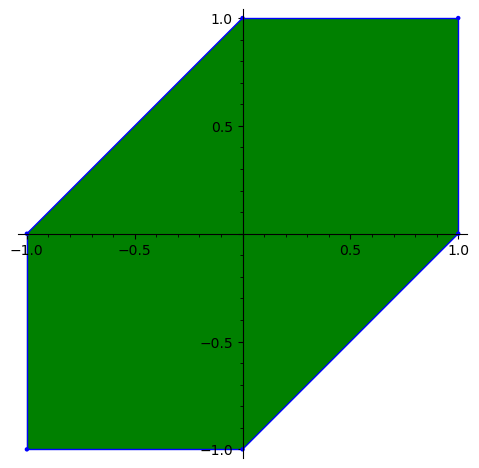

In [3]:
## HELPER FUNCTIONS - Creating alcoved polytopes aka polytropes, our main "playing field" for this project.

# INPUT: A single list of integer b_ijs of length dim_polytope*(dim_polytope+1), in standard order (b_11, ..., b_1(d+1), b_21, ..., b_2(d+1), ...).
# OUTPUT: A Polyhedron corresponding to the full-dimensional polytrope defined by the inequalities x_i - x_j <= b_ij
def polytrope(list_of_b_i_js):
    if len(list_of_b_i_js) != dim_polytope*(dim_polytope+1):
        raise ValueError("list_of_b_i_js must be length " + str(dim_polytope*(dim_polytope+1)))
    polytrope_inequalities = []
    current_index = 0
    for i in range(1, dim_polytope+2):
        for j in range(1, dim_polytope+2):
            if i != j:
                #Inequality is of the form x_i - x_j <= b_{ij}. SageMath's notation is to interpret inequality tuple (b, A) as Ax + b >= 0
                #So in our case, our inequality can be rewritten as x_j - x_i + b_{ij} >= 0
                #This means set index j to 1, index i to -1, a_{ij} to index 0. 
                #The current a_ij is indexed using current_index

                #Initialize inequality tuple
                i_j_inequality = [0]*(dim_polytope+1)
                
                # Set b_ij to index 0.
                i_j_inequality[0] = list_of_b_i_js[current_index]

                # Set index j to 1, index i to -1, unless if i or j is equal to dim_polytope+1
                if i != dim_polytope+1:
                    i_j_inequality[i] = -1
                if j != dim_polytope+1:
                    i_j_inequality[j] = 1

                #Now that we have our tuple, add it to polytrope inequalities and increase index of current a_ij we are on
                i_j_inequality_tuple = tuple(i_j_inequality)
                polytrope_inequalities.append(i_j_inequality)
                current_index += 1
                
    return(Polyhedron(ieqs=polytrope_inequalities))

## Generates a list of b_i_j that correspond to input, with b_i_j satisfying triangle inequalities.
# (in the case of degenerate alcoved polytopes, the inequalities will become strict equalities)
# Dev note: Does not fully work in higher dimension, may need to switch to P_to_B.
# INPUT: A Polyhedron corresponding to an alcoved polytrope
def polytrope_to_b(P):
    # Retrieve a list of vertices to iterate over.
    V=P.vertices()

    # Create matrix B to store the list of b_i_j. Iterate over the list of vertices and evaluate x_i - x_j on each vertex, take the maximum value.
    B=[[0 for i in range(dim_polytope+1)] for j in range(dim_polytope+1)]
    for i in range(dim_polytope):
        B[i][dim_polytope]=max(v[i] for v in V)
        B[dim_polytope][i]=max(-v[i] for v in V)
        for j in range(dim_polytope):
            B[i][j]=max(v[i]-v[j] for v in V)

    # Flatten B into b_list.
    b_list=[]
    for i in range(dim_polytope+1):
        for j in range(dim_polytope+1):
            if i!=j: b_list.append(B[i][j])
    return(b_list)
    

# Sample runs of the above code. Only works dimension 2.
if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting sample run.")
else:
    test_polytrope = polytrope([1, 1, 1, 1, 1, 1]) #should return a polytrope with vertices (-1, -1), (-1, 0), (0, 1), (1, 1), (1, 0), (0, -1)
    test_polytrope.show()

In [4]:
## HELPER FUNCTIONS - check if polytope is unimodular or alcoved. Creates random polytrope.

## Calculates determinant of a matrix using cofactor expansion.
# INPUT: A Matrix M in SageMath.
# OUTPUT: Determinant of said matrix.
def determinant_of_matrix(M):
    # In the weird case that a submatrix is returned as an rational or an integer.
    if type(M) == sage.rings.rational.Rational or type(M) == sage.rings.integer.Integer:
        return M
    elif M.nrows() == 0:
        return 0
    elif M.nrows() == 1:
        return M[0][0]
    elif M.nrows() != M.ncols():
        return 0
    sum = 0
    # i = 0 case
    sum += (-1)^0 * M[0][0] * determinant_of_matrix(determinant_of_matrix(M.submatrix(1, 1)))

    # middle case
    for i in range(1, M.ncols() - 1):
        sum += (-1)^i * M[0][i] * determinant_of_matrix(M.submatrix(1, 0, ncols = i).augment(M.submatrix(1, i+1, ncols = M.ncols() - i - 1)))

    # i = M.ncols() - 1 case
    sum += (-1)^(M.ncols() - 1) * M[0][M.ncols() - 1] * determinant_of_matrix(M.submatrix(1, 0))
    return sum

## Check if polytope is a simple polytope by iterating through the vertices and checking that exactly d hyperplanes intersect at each point. 
# INPUT: A Polyhedron P in SageMath.
# OUTPUT: A boolean indicating if unimodular or not.
def check_if_simple(P):
    for vertex in P.Vrepresentation():
        # count the number of hyperplanes touching each vertex, should be equal to dim_polytope.
        num_hyperplanes = 0
        for hyp in vertex.incident():
            num_hyperplanes += 1
        if num_hyperplanes != dim_polytope:
            return False
    return True

## Check if polytope P is a unimodular polytope. By unimodular, we mean that the matrix A in the linear inequality representation Ax + b >= 0 that A is totally unimodular
# or that each of the d by d minors of A are in the set {-1, 0, 1}. Moreover, we check that the associated b is chosen such that P is simple.
# INPUT: A Polyhedron P in SageMath.
# OUTPUT: A boolean indicating if unimodular or not.
def check_if_unimodular(P):
    # Extract the matrix in P by iterating through hyperplanes and constructing a matrix.
    list_of_rows = []
    for hyp in P.Hrepresentation():
        # Each hyperplane is of the form Ax + b >= 0 (or equivalently -Ax <= b), we extract -A.
        list_of_rows.append(-hyp.A())
    # Create matrix from list_of_rows
    P_matrix = matrix(list_of_rows)
    # Now check if this matrix is totally unimodular, i.e, every square minor is of determinant -1, 0, 1. We do this naively, as there is no neat implementation.
    for size_of_minor in range(1, min(P_matrix.nrows(), P_matrix.ncols()) + 1):
        for start_row_index in range(0, P_matrix.nrows() - size_of_minor + 1):
            for start_col_index in range(0, P_matrix.ncols() - size_of_minor + 1):
                determinant_of_submatrix = determinant_of_matrix(P_matrix.submatrix(start_row_index, start_col_index, size_of_minor, size_of_minor))
                if determinant_of_submatrix == 0:
                    pass
                elif determinant_of_submatrix == 1:
                    pass
                elif determinant_of_submatrix == -1:
                    pass
                else:
                    return False
    if not check_if_simple(P):
        return False
    return True

## Check if polytope is a (degenerate) alcoved polytope. By degenerate alcoved polytope, we mean the facets are still of the form x_i - x_j <= b_ij, but
# the b_ij do not necessarily satisfy the triangle inequality and not all facets are present.
# INPUT: A Polyhedron P in SageMath.
# OUTPUT: A boolean indicating if (degenerate) alcoved or not.
def check_if_alcoved(P):
    for hyp in P.Hrepresentation():
        # Each hyperplane is of the form Ax + b >= 0, we investigate the A and check if there is exactly at most one +1 and at most one -1 out of the NONZERO entries.
        hyp_normal = hyp.A()
        pos_one_count = 0
        neg_one_count = 0
        for i in range(len(hyp_normal)):
            if hyp_normal[i] == -1:
                neg_one_count += 1
            elif hyp_normal[i] == 1:
                pos_one_count += 1
            elif hyp_normal[i] == 0:
                pass
            else:
                return False
        if pos_one_count > 1 or neg_one_count > 1:
            return False
    return True

## Check if polytope is a strictly alcoved polytope. That means all facets of the form x_i - x_j <= b_ij are present.
# INPUT: A Polyhedron P in SageMath.
# OUTPUT: A boolean indicating if alcoved or not.
def check_if_strictly_alcoved(P):
    num_hyperplanes = 0
    for hyp in P.Hrepresentation():
        # Each hyperplane is of the form Ax + b >= 0, we investigate the A and check if there is exactly at most one +1 and at most one -1 out of the NONZERO entries.
        hyp_normal = hyp.A()
        pos_one_count = 0
        neg_one_count = 0
        for i in range(len(hyp_normal)):
            if hyp_normal[i] == -1:
                neg_one_count += 1
            elif hyp_normal[i] == 1:
                pos_one_count += 1
            elif hyp_normal[i] == 0:
                pass
            else:
                return False
        if pos_one_count > 1 or neg_one_count > 1:
            return False
    if num_hyperplanes != dim_polytope * (dim_polytope+1):
        return False
    return True

# No sample output available, used primarily in random_polytrope.

Creating a random polytope


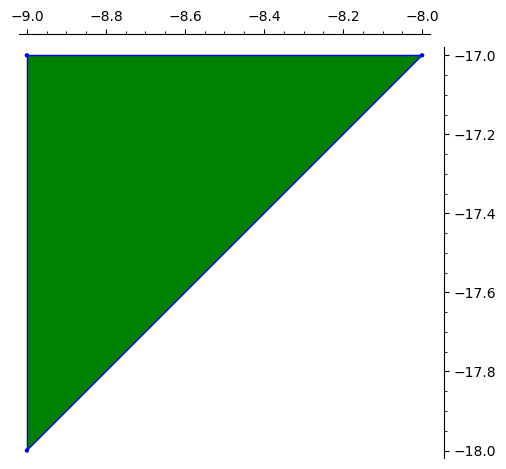

Printing out corresponding b_i_j (flattened down to satisfy triangle inequalities):
[9, -8, -8, -17, 9, 18]

Now we demonstrate 3 cases testing if our polytopes are unimodular, alcoved, and strict alcoved

Case 1


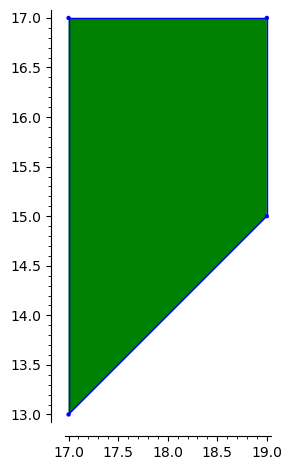

True
True
False

Case 2


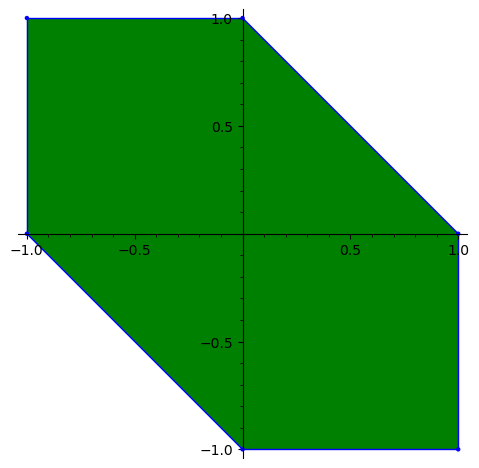

True
False
False

Case 3


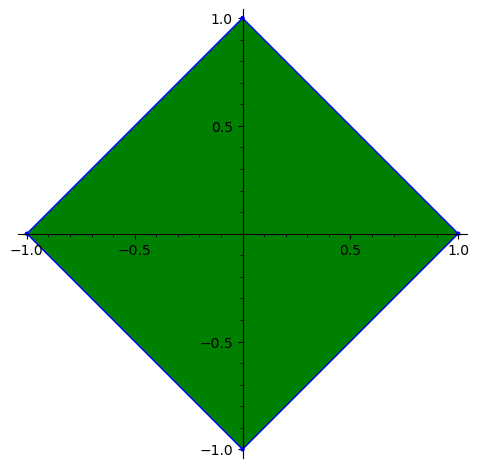

False
False
False


In [5]:
## Generates a random polytrope with b_ij's in (-20,20)
# WARNING: This does not check for triangle inequalities, merely that the resulting shape is 
# full dimensional, so you may get degenerate alcoved polytopes.
# However, our weighted count code will still work on degenerate alcoved polytopes (as long as they are unimodular).
def random_polytrope():
    P = polytrope([randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))])
    if dim(P)<dim_polytope or not check_if_unimodular(P): return(random_polytrope())
    return(P)

# Sample runs of the above code (note determinant is only a helper function in check_if_unimodular)
# Only works dimension 2.
if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting sample run.")
else:
    print("Creating a random polytope")
    rand_poly = random_polytrope()
    rand_poly.show() #should return a random (possibly degenerate) polytrope.
    print("Printing out corresponding b_i_j (flattened down to satisfy triangle inequalities):")
    print(polytrope_to_b(rand_poly))
    print()
    print("Now we demonstrate 3 cases testing if our polytopes are unimodular, alcoved, and strict alcoved")
    print()
    print("Case 1")
    rand_polytrope = random_polytrope()
    rand_polytrope.show()
    print(check_if_unimodular(rand_polytrope))
    print(check_if_alcoved(rand_polytrope))
    print(check_if_strictly_alcoved(rand_polytrope))
    print()
    
    print("Case 2")
    just_unimodular_polytope = Polyhedron(vertices = [(-1, 0), (-1, 1), (0, 1), (1, 0), (1, -1), (0, -1)]) # Should be a polytope with vertices (-1, 0), (-1, 1), (0, 1), (1, 0), (1, -1), (0, -1). A mirror image of a 2d polytrope
    just_unimodular_polytope.show()
    print(check_if_unimodular(just_unimodular_polytope))
    print(check_if_alcoved(just_unimodular_polytope))
    print(check_if_strictly_alcoved(just_unimodular_polytope))
    print()
    
    print("Case 3")
    non_unimodular_polytope = Polyhedron(ieqs = [(1, -1, -1), (1, -1, 1), (1, 1, 1), (1, 1, -1)]) #Should be a polytope with vertices (-1, 0), (0, 1), (1, 0), (0, -1)
    non_unimodular_polytope.show()
    print(check_if_unimodular(non_unimodular_polytope))
    print(check_if_alcoved(non_unimodular_polytope))
    print(check_if_strictly_alcoved(non_unimodular_polytope))

In [6]:
## Given a degenerate alcoved polytope, we perturb its facets to obtain a maximal alcoved polytope with C(2d, d) vertices.

# We use the following helper function, which converts a polytope into a matrix B, with B_ij representing the facet x_i - x_j <= b_ij.
def P_to_B(P):
    V=P.vertices()
    d=dim(P)
    B=[[0 for i in range(d+1)] for j in range(d+1)]
    for i in range(d):
        B[i][d]=max(v[i] for v in V)
        B[d][i]=max(-v[i] for v in V)
        for j in range(d):
            B[i][j]=max(v[i]-v[j] for v in V)    
    B_list=[]
    for i in range(d+1):
        for j in range(d+1):
            if i!=j: B_list.append(B[i][j])
    return(B_list)


# This helper function creates a dictionary between the kth position (0-indexed) in the list [(i, j) | i != j] with the kth ordered pair (i, j).
# Ex: Say 1 <= i, j <= 3. Then position 1 (1-indexed) maps to (1, 2) (since (1, 1) is not allowed), position 2 maps to (1, 3), and position 3
# maps to (2, 1).
def k_to_bij_dict(d):
    D = {}
    c = 0
    for i in range(1, d+2):
        for j in range(1, d+2):
            if i != j:
                D[c] = (i, j)
                c += 1
    return(D)

# This helper function creates a dictionary between each ij index and its position in the list [(i, j)], performing the inverse of the above.
def bij_to_k_dict(d):
    return({v: k for k, v in k_to_bij_dict(d).items()})

# List all facets of P.
def all_ij_facets(P):
    F=[]
    for f in P.facets():
        ieq = f.ambient_Hrepresentation()
        ij=facet_ieq_to_bij(ieq)
        F.append(ij)
    return(F)

# Convert each facet of x_i - x_j <= bij into left hand side x_i - x_j, returning [i, j].
def facet_ieq_to_bij(ieq):
    vec = list(ieq[0][1:])
    d=len(vec)
    mins = min(abs(x) for x in vec if x != 0)
    vec = [x/mins for x in vec]
    i= -1 
    j = -1
    if 1 in vec: 
        j=vec.index(1)+1
    if -1 in vec: i=vec.index(-1)+1
    if i==-1: i=d+1
    if j==-1: j=d+1
    return([i,j])

## Recover a maximal alcoved polytope with the maximal number of vertices by perturbing the facets by a small amount.
## INPUT: P, a Polyhedron in SageMath corresponding to a integral degenerate alcoved polytope. 
## OUTPUT: P', a Polyhedron in SageMath corresponding to a integral maximal alcoved polytope.
def make_P_generic_alcoved(P, eps = 1/2):
    d=dim(P)
    if P.n_vertices()==binomial(2*d,d): 
        # Terminate when maximal number of vertices is listed.
        return(P)
    if eps<1/2^(1+binomial(2*d,d)):
        # Part of debugging, prevents infinite loop.
        P.show()
        raise ValueError('exceeded maximum number of needed recursions')
    B=P_to_B(P)
    facets=all_ij_facets(P)
    # We keep track of whether we move a facet. We stop the following for loops once one facet has been moved
    # that increases the number of vertices in P_to_B by setting moved = True.
    moved=False
    for i in range(1,d+2):
        for j in range(1,d+2):
            if i!=j and ([i,j] not in facets) and moved==False:
                D=bij_to_k_dict(d)
                B[D[(i,j)]]-=eps #moves in facet by eps if possible
                moved=True
    if moved==False:
        for v in P.vertices():
            if sum(1 for f in P.facets() if v in f) != d:
                for f in P.facets():
                    # if no facet was moved above, we move in some facet
                    if v in f and moved==False:
                        ieq = f.ambient_Hrepresentation()
                        ij=facet_ieq_to_bij(ieq)
                        D=bij_to_k_dict(d)
                        B[D[tuple(ij)]]+= eps #moves out a facet associated with some vertex.
                        # If this move does not increase the number of vertices, move onto the next facet and revert the above move.
                        if polytrope(B).n_vertices() > P.n_vertices():
                            moved=True
                        else:
                            B[D[tuple(ij)]] -= eps
    
    return(make_P_generic_alcoved(polytrope(B),eps/2))

if dim_polytope <= 4:
    print("This code creates a random possibly degenerate alcoved polytope P and generalizes it to a maximal alcoved polytope Q.")
    P=random_polytrope()
    Q=make_P_generic_alcoved(P)  
    print("The number of facets of Q is", Q.n_facets())
    print("The number of vertices of Q is", Q.n_vertices())
    Q.plot() 
else:
    print("This code creates a random possibly degenerate alcoved polytope P and generalizes it to a maximal alcoved polytope Q.")
    P=random_polytrope()
    Q=make_P_generic_alcoved(P)  
    print("The number of facets of Q is", Q.n_facets())
    print("The number of vertices of Q is", Q.n_vertices())

This code creates a random possibly degenerate alcoved polytope P and generalizes it to a maximal alcoved polytope Q.
The number of facets of Q is 6
The number of vertices of Q is 6


Case 1


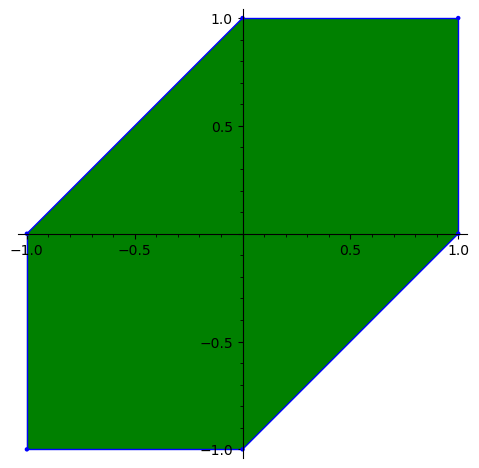

This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (-1, 0) x + 1 >= 0 transformed into generic hyperplane (-1, 0)x + b_1 + h_1 >= 0
An inequality (-1, 1) x + 1 >= 0 transformed into generic hyperplane (-1, 1)x + b_2 + h_2 >= 0
An inequality (0, -1) x + 1 >= 0 transformed into generic hyperplane (0, -1)x + b_3 + h_3 >= 0
An inequality (1, 0) x + 1 >= 0 transformed into generic hyperplane (1, 0)x + b_4 + h_4 >= 0
An inequality (0, 1) x + 1 >= 0 transformed into generic hyperplane (0, 1)x + b_5 + h_5 >= 0
An inequality (1, -1) x + 1 >= 0 transformed into generic hyperplane (1, -1)x + b_6 + h_6 >= 0
[[b_2 - b_5 + h_2 - h_5, -b_5 - h_5], [b_1 + h_1, b_3 + h_3], [b_1 + h_1, b_1 - b_2 + h_1 - h_2], [b_3 - b_6 + h_3 - h_6, b_3 + h_3], [-b_4 - h_4, -b_4 + b_6 - h_4 + h_6], [-b_4 - h_4, -b_5 - h_5]]

Case 

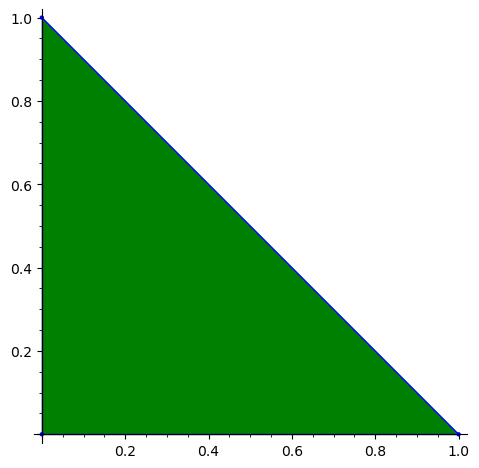

This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (-1, -1) x + 1 >= 0 transformed into generic hyperplane (-1, -1)x + b_1 + h_1 >= 0
An inequality (1, 0) x + 0 >= 0 transformed into generic hyperplane (1, 0)x + b_2 + h_2 >= 0
An inequality (0, 1) x + 0 >= 0 transformed into generic hyperplane (0, 1)x + b_3 + h_3 >= 0
[[b_1 + b_3 + h_1 + h_3, -b_3 - h_3], [-b_2 - h_2, b_1 + b_2 + h_1 + h_2], [-b_2 - h_2, -b_3 - h_3]]

Case 3 - same as Case 2, but fixed


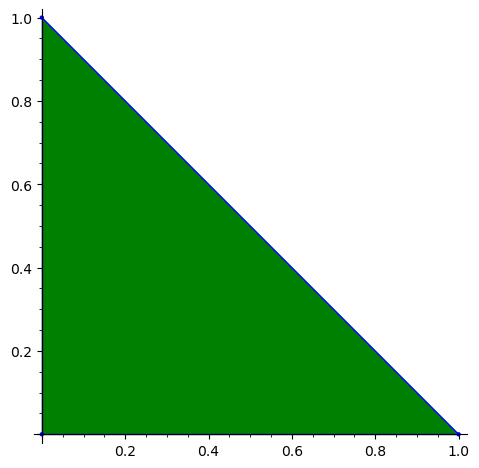

This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (-1, -1) x + 1 >= 0 transformed into generic hyperplane (-1, -1)x + 1 + h_1 >= 0
An inequality (1, 0) x + 0 >= 0 transformed into generic hyperplane (1, 0)x + 0 + h_2 >= 0
An inequality (0, 1) x + 0 >= 0 transformed into generic hyperplane (0, 1)x + 0 + h_3 >= 0
[[h_1 + h_3 + 1, -h_3], [-h_2, h_1 + h_2 + 1], [-h_2, -h_3]]
Sample code part 2 only works for dimension 3, omitting sample run.


In [7]:
## HELPER FUNCTIONS - this function takes in a fixed integral unimodular polytrope P and returns a list of vertices
# corresponding to the generic version of said polytope. By generic, we mean that the hyperplanes are allowed to vary, as
# long as the resulting polytope belongs to the same combinatorial type (part of the same secondary cone/type cone) as the original.

# For example, a right triangle in R^2 with hyperplanes 1x + 0y >= 0, 0x + 1y >= 0, -1x - 1y >= -1 gets transformed into 
# a generalized right triangle with hyperplanes 1x + 0y >= b_1 + h_1, 0x + 1y >= b_2 + h_2, -1x -1y >= b_3 + h_3. 
# This function then returns a list of vertices corresponding to the shifted polytope defiend above (which is used especially in volume_simplex).
# Again, we assume the b_k values correspond to the same combinatorial type as the original right triangle.

# INPUT: P, a Polyhedron in SageMath corresponding to a integral unimodular polytope. Defined as the solution set to Ax + b' >= 0 (for fixed A and b')
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
# INPUT: fixed - If True, then do not generalize right triangle (add in b_i_j) and just keep original polytope and set of vertices perturbed by h. Set to False by default.
# OUTPUT: A list of vertices corresponding to the solution set Ax + (b + h) >= 0, where h is a small perturbation and b is a generic set of variables.
# OUTPUT: b_k_variables, h_variables - variables created by this function, used later in the program.

def generic_integral_unimodular_polytope(P, suppress_output = False, fixed = False):
    
    # Prints out information (if suppress_output == True) about each hyperplane of the original polytope P 
    # of the form A_{k}x + b_{k}' >= 0 and how it is shifted over to A_{k}x + (b_k + h_k) >= 0.
    # We also create a dictionary between each hyperplane to its shifted form.
    if not suppress_output:
        print("This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.")
    current_index = 1
    b_k_variables = []
    h_variables = []
    from_generic_hyperplane_to_shifted_equation_dict = {}
    for hyperplane in P.Hrepresentation():
        if not suppress_output and not fixed:
            print(str(hyperplane) + " transformed into generic hyperplane " + str(hyperplane.A()) + 
              "x + b_" + str(current_index) + " + h_" + str(current_index) + " >= 0")
        if not suppress_output and fixed:
            print(str(hyperplane) + " transformed into generic hyperplane " + str(hyperplane.A()) + 
              "x + " + str(hyperplane.b()) + " + h_" + str(current_index) + " >= 0")
        if not fixed:
            b_k_variables.append(var('b_' + str(current_index)))
        h_variables.append(var('h_' + str(current_index)))

        if not fixed:
            new_expr = var('b_' + str(current_index)) + var('h_' + str(current_index))
        else:
            new_expr = hyperplane.b() + var('h_' + str(current_index))
        for i in range(0, dim_polytope):
            new_expr = new_expr + hyperplane.A()[i] * var('x_' + str(i+1))
        from_generic_hyperplane_to_shifted_equation_dict[hyperplane] = new_expr
        current_index += 1

    # Compiles a new list of vertices based off our shifted hyperplanes.
    # For each vertex in the original polytope, map each of the hyperplanes to their shifted counterpart and then compute their intersection.
    # We do this because SageMath does not support generalized Polyhedra with variable coordinates.
    # We will use this vertex representation in the main functions to compute the integral of w(x) over P(b_i).
    new_list_of_vertices = []
    for vertex in P.Vrepresentation():
        # compile a list of hyperplanes touching each vertex, convert them to their shifted expressions (left hand side of new shifted inequalities)
        # and then solve for all of these equations set to 0.
        list_of_equations = []
        for hyperplane in vertex.incident():
            list_of_equations.append(from_generic_hyperplane_to_shifted_equation_dict[hyperplane])
        new_vertex = solve(list_of_equations, variables)[0] 
        new_vertex = list(map(lambda item : item.rhs(), new_vertex))
        new_list_of_vertices.append(new_vertex)

    return new_list_of_vertices, b_k_variables, h_variables

# Sample runs of the above code. Only works dimension 2.
if dim_polytope != 2:
    print("Sample code part 1 only works for dimension 2, omitting sample run.")
else:
    print("Case 1")
    test_polytrope = polytrope([1, 1, 1, 1, 1, 1]) #should return a polytrope with vertices (-1, -1), (-1, 0), (0, 1), (1, 1), (1, 0), (0, -1)
    test_polytrope.show()
    new_list_of_vertices, b_k_variables, h_variables = generic_integral_unimodular_polytope(test_polytrope, suppress_output = False, fixed = False) 
    #this function symbolically generates a list of vertices corresponding to the shifted polytope described above.
    print(new_list_of_vertices)
    print()
    
    print("Case 2")
    right_triangle = Polyhedron(ieqs = [(0, 1, 0), (0, 0, 1), (1, -1, -1)]) #should return a polytope with vertices (0, 0), (0, 1), (1, 0).
    right_triangle.show()
    new_list_of_vertices, b_k_variables, h_variables = generic_integral_unimodular_polytope(right_triangle, suppress_output = False, fixed = False) 
    #this function symbolically generates a list of vertices corresponding to the shifted right triangle described above.
    print(new_list_of_vertices)
    print()

    print("Case 3 - same as Case 2, but fixed")
    right_triangle = Polyhedron(ieqs = [(0, 1, 0), (0, 0, 1), (1, -1, -1)]) #should return a polytope with vertices (0, 0), (0, 1), (1, 0).
    right_triangle.show()
    new_list_of_vertices, b_k_variables, h_variables = generic_integral_unimodular_polytope(right_triangle, suppress_output = False, fixed = True) 
    #this function symbolically generates a list of vertices corresponding to the shifted right triangle described above.
    print(new_list_of_vertices)


if dim_polytope != 3:
    print("Sample code part 2 only works for dimension 3, omitting sample run.")
else:
    test_polytrope = random_polytrope() 
    test_polytrope.show()
    new_list_of_vertices, b_k_variables, h_variables = generic_integral_unimodular_polytope(test_polytrope, suppress_output = False, fixed = False) 
    #this function symbolically generates a list of vertices corresponding to the shifted polytope described above.
    print(new_list_of_vertices)

In [8]:
## HELPER FUNCTIONS - setting up Todd computations used in `integral_unimodular_polytope_shifted_by_h`

## takes the kth derivative of a function f with respect to variable x
def k_deriv(f,x,k):
    for i in range(k):
        f=derivative(f,x)
    return(f)

## Univariate Todd operator for a polynomial f with respect to variable x
def Todd(f,x):
    return(sum(((-1)^k*bernoulli(k)/factorial(k)*k_deriv(f,x,k)) for k in range(f.degree(x)+1)))

## Multivariate Todd operator for a polynomial f (<class 'sage.symbolic.expression.Expression'> in SageMath) with respect to multiple variables
def Todd_multivariate(f, variables_to_derive):
    g = f
    for variable in variables_to_derive:
        g = Todd(g, variable)
    return g

# Sample run of the above code (note k_deriv is a helper function in Todd, note Todd_multivariate just repeatedly calls Todd on different variables)
# (This is mainly used in Todd_multivariate)
var('h')
test_expression = h^2
print(Todd(test_expression, h))

h^2 + h + 1/6


In [9]:
## HELPER FUNCTIONS - setting up iterative methods needed in our implementation o f Theorem 3.3, `integral_simplex`

## list of all strings of length n with characters 0 & 2 (will subtract 1 to get -1 & 1)
def bin(n): return(Words(alphabet='02', length=n))

## recursively define for loops to nest arbitrarily many
def nestedfor(M,start,end):
    for i1 in range(start,end):
        if M==1: yield[i1]
        else:
            for others in nestedfor(M-1,i1,end):
                yield [i1]+others

## returns list of all multisets of {0,...,d} of length M
def multiset(M,d):
    if M==0: return([])
    return(list(nestedfor(M,0,d)))

# Sample runs of the above code (note nestedfor is only a helper function in multiset) (both of these are primarily used in integral_simplex)
print(bin(3))
print(multiset(3, 6))

Words of length 3 over {'0', '2'}
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5], [0, 2, 2], [0, 2, 3], [0, 2, 4], [0, 2, 5], [0, 3, 3], [0, 3, 4], [0, 3, 5], [0, 4, 4], [0, 4, 5], [0, 5, 5], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 1, 5], [1, 2, 2], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 3], [1, 3, 4], [1, 3, 5], [1, 4, 4], [1, 4, 5], [1, 5, 5], [2, 2, 2], [2, 2, 3], [2, 2, 4], [2, 2, 5], [2, 3, 3], [2, 3, 4], [2, 3, 5], [2, 4, 4], [2, 4, 5], [2, 5, 5], [3, 3, 3], [3, 3, 4], [3, 3, 5], [3, 4, 4], [3, 4, 5], [3, 5, 5], [4, 4, 4], [4, 4, 5], [4, 5, 5], [5, 5, 5]]


## Main Functions
Explanations given for each of the code blocks.
- Given a list of vertices of a simplex $S$, functions here compute the volume of $S$ and the integral of $w(x)$ over $S$ (which implements Theorem 3.3 in our paper).
- Given a unimodular polytope $P$, create $P(h)$ and compute the integral $\int_{P(h)} w(x) dx$. Apply the multivariate Todd operator on this integral in order to get the weighted point count.
- Given an alcoved polytope $P$, do the same as above. We do this separately due to separate variable conventions.

In [10]:
## MAIN FUNCTIONS - given a list of d + 1 vertices corresponding to a d dimensional simplex, 
# these functions computes the volume of S and the integral of w(x) over S

## computes the volume of the (dim_polytope) simplex defined by the vertices S_vertices
# We utilize the formula on https://www.mathpages.com/home/kmath664/kmath664.htm
# We shift all other vertices by S_vertices[0], take determinant, divide by factorial(dim_polytope).
# NOTE: Does not account for sign, you have to manually check for sign yourself (as we do in `integral_unimodular_polytope_shifted_by_h`).

# INPUT: S_vertices is a list of vertices (length (dim_polytope+1)) that correspond to a simplex.

import copy
def volume_simplex(S_vertices):
    # Ensure that S_vertices input is valid.
    if len(S_vertices) != dim_polytope+1:
        raise ValueError("S_vertices must be length " + str(dim_polytope+1))
    if len(S_vertices[0]) != dim_polytope:
        raise ValueError("S_vertices[0] (and all other vertices) must be length " + str(dim_polytope))
        
    # Do a deep copy of S_vertices to ensure original data isn't cleared out.
    shifted_S_vertices = deepcopy(S_vertices) 
    
    # Shift all vertices by S_vertices[0] and then remove it
    for i in range(1, len(shifted_S_vertices)):
        for j in range(dim_polytope):
            shifted_S_vertices[i][j] -= shifted_S_vertices[0][j]
    throwaway = shifted_S_vertices.pop(0)

    # Compute determinant divided by factorial(dim_polytope)
    A = Matrix(shifted_S_vertices)
    return A.determinant()/factorial(dim_polytope)
    
## computes the integral of w(x_1, ..., x_(dim_polytope)) homogeneous in R_vars over a (dim_polytope)-dimensional simplex S with vertices 
# S_vertices=[v1, ..., v_(dim_polytope+1)], where each v is a vector in R^(dim_polytope).
# We utilize "How To Integrate a Polynomial over a Simplex" by Baldoni, Berline, De Loera, Koppe, and Vergne, Corollary 18, also listed as
# Theorem 3.3 in our paper.

# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: S_vertices is a list of vertices (length (dim_polytope+1)) that correspond to a simplex.
# NOTE: S_vertices can take in input including a shift by variables as well, assuming those variables are negligibly small and do not 
# affect the combinatorial type of simplex, for example: P_vertices = [[2 + h, 1 + k], [5 + l, 6 + m]] is a valid input assuming that
# h, k, l, m are arbitrarily small. This is useful for our other functions later on.     

def integral_simplex(w, S_vertices):
    # Ensure that S_vertices is valid.
    if len(S_vertices) != dim_polytope+1:
        raise ValueError("S_vertices must be length " + str(dim_polytope+1))
    if len(S_vertices[0]) != dim_polytope:
        raise ValueError("S_vertices[0] (and all other vertices) must be length " + str(dim_polytope))

    # Compute coefficient in formula. If w = 0, then this coefficient is equivalent to the volume of the simplex and we just return it.
    coeff = volume_simplex(S_vertices)/(2^(w.degree())*factorial(w.degree())*binomial(w.degree()+dim_polytope, w.degree()))
    if w.degree() == 0:
        return(coeff)

    # We compute the alternating sum of sgn(prod(b_k)) * f(sum b_k * s_i_k)  
    # over all multisets (with each element signed by b) 
    # of length w.degree() from the d+1 vertices of S_vertices.
    sum = 0
    #I is our list of (not necessarily unique!) w.degree() elements from the d+1 vertices of S_vertices.
    for I in multiset(w.degree(), dim_polytope+1):
        #l (equivalently b) is a list representing the sign on each of those elements. c is the product of all elements in l.
        # We now compute each term in Theorem 3.3 mentioned above.
        for l in bin(w.degree()):
            b = list(l)
            c = prod(int(i) - 1 for i in b)
            #sum accordingly to get our signed_input to feed into w.
            signed_input = [0] * (dim_polytope)
            for i in range(w.degree()): 
                for j in range(dim_polytope):
                    signed_input[j] += (int(b[i])-1)*S_vertices[I[i]][j]
            sum += c * w(*signed_input) #unpack all the elements of signed_input into w for evaluation.
    return(coeff*sum)

# Sample runs of the above code (note determinant is only a helper function in check_if_unimodular)
# Note that in our code, the order of the vertices is always chosen (internally by SageMath) to avoid sign error
# Only works dimension 2.
if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting sample run.")
else:
    print("Case 1: fixed shape")
    print("volume of fixed simplex:")
    print(volume_simplex([[0, 0], [1, 0], [0, 1]]))
    print("integral of x_1^2 over fixed simplex:")
    print(integral_simplex(R_vars(x_1^2), [[0, 0], [1, 0], [0, 1]]))
    print()
    
    print("Case 2: generalized shape")
    test_simplex = Polyhedron(vertices = [(0, 0), (1, 0), (0, 1)])
    new_list_of_vertices, b_k_variables, h_variables = generic_integral_unimodular_polytope(test_simplex, suppress_output = False, fixed = False) 
    print(new_list_of_vertices)
    print()
    print("volume of general simplex:")
    print(volume_simplex(new_list_of_vertices))
    print("integral of x_1^2 over general simplex:")
    print(integral_simplex(R_vars(x_1^2), new_list_of_vertices))

Case 1: fixed shape
volume of fixed simplex:
1/2
integral of x_1^2 over fixed simplex:
1/12

Case 2: generalized shape
This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (1, 0) x + 0 >= 0 transformed into generic hyperplane (1, 0)x + b_1 + h_1 >= 0
An inequality (0, 1) x + 0 >= 0 transformed into generic hyperplane (0, 1)x + b_2 + h_2 >= 0
An inequality (-1, -1) x + 1 >= 0 transformed into generic hyperplane (-1, -1)x + b_3 + h_3 >= 0
[[-b_1 - h_1, -b_2 - h_2], [-b_1 - h_1, b_1 + b_3 + h_1 + h_3], [b_2 + b_3 + h_2 + h_3, -b_2 - h_2]]

volume of general simplex:
-1/2*(b_1 + b_2 + b_3 + h_1 + h_2 + h_3)^2
integral of x_1^2 over general simplex:
1/24*((b_1 + b_2 + b_3 + h_1 + h_2 + h_3)^2 - (b_1 - b_2 - b_3 + h_1 - h_2 - h_3)^2 - 6*(b_1 + h_1)^2 - 2*(b_2 + b_3 + h_2 + h_3)^2)*(b_1 + b_2 + b_3 + h_1 

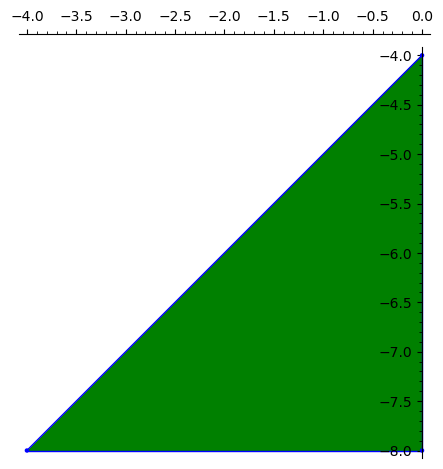

integral of x_1^2 over generalized polytrope:
This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (-1, 0) x + 0 >= 0 transformed into generic hyperplane (-1, 0)x + b_1 + h_1 >= 0
An inequality (1, -1) x - 4 >= 0 transformed into generic hyperplane (1, -1)x + b_2 + h_2 >= 0
An inequality (0, 1) x + 8 >= 0 transformed into generic hyperplane (0, 1)x + b_3 + h_3 >= 0
(-1/24*((b_1 + b_2 + b_3 + h_1 + h_2 + h_3)^2 - (b_1 - b_2 - b_3 + h_1 - h_2 - h_3)^2 - 6*(b_1 + h_1)^2 - 2*(b_2 + b_3 + h_2 + h_3)^2)*(b_1 + b_2 + b_3 + h_1 + h_2 + h_3)^2, [b_1, b_2, b_3], [h_1, h_2, h_3])

Todd operator applied on above integral, should result in weighted point count:
This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True,

In [11]:
## MAIN FUNCTIONS - takes a homogeneous polynomial w over our dim_polytope-dimensional ring R_vars and 
# integrates it over an arbitrary dim_polytope-dimensional integral unimodular polytope P(h). 
# The final output polynomials are in terms of b_ks (correspond to each hyperplane of unimodular P(h)) 
# and h_i_js (in Todd_count, h_i_js are all set to 0 by the end)

## computes the integral of w(x_1, ..., x_(dim_polytope)) homogeneous in R_vars over an arbitrary (dim_polytope)-dimensional integral 
# unimodular polytope P(h) with P having the same combinatorial type as the unimodular polytope with vertices P_vertices.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P is a fixed unimodular polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
# INPUT: fixed - If True, then do not generalize right triangle (add in b_i_j) and just keep original polytope and set of vertices. Set to False by default.
# Note that this will just return the weighted count of the original polytope P.

def integral_unimodular_polytope_shifted_by_h(w, P, suppress_output = False, fixed = False):
    
    #Compute a triangulation of P.
    PointConfiguration.set_engine('internal')
    points = PointConfiguration(P.Vrepresentation())
    triangulation = points.triangulate()

    #Transform P (defined by P_vertices) into a generic unimodular polytope by replacing the inequalities Ax + b >= 0
    # (defined by specific values b forming P) with Ax + (b_k + h_k) >= 0.
    Ph_vertices, b_k_variables, h_variables= generic_integral_unimodular_polytope(P, suppress_output, fixed)

    #For some reason, P.Vrepresentation()[i] is immutable, so we make our own mutable copy.
    P_vertices = []
    for vertex in P.Vrepresentation():
        new_vertex = [0] * (dim_polytope)
        for j in range(dim_polytope):
            new_vertex[j] = vertex[j]
        P_vertices.append(new_vertex)
    
    # Over all simplices part of P(h), compute the integral of w over each simplex.
    sum = 0
    for simplex_selection in triangulation:
        # NOTE FROM DEVS: Based off order of triangulation, the vertices are always clockwise, so the sign will always be (-1)^(dim+1).
        sign_of_volume = sgn(volume_simplex(list(map(lambda i : P_vertices[i], simplex_selection))))
        sum += sign_of_volume * integral_simplex(w, list(map(lambda i : Ph_vertices[i], simplex_selection)))
    return sum, b_k_variables, h_variables

## applies Todd operator to integral of w(x_1, ..., x_(dim_polytope)) over an arbitrary integral unimodular polytope P(h)
# with P having the same combinatorial type as the integral unimodular polytope with vertices P_vertices.
# This should result in the weighted integer point count by weighted K-P.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P a fixed unimodular polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
# INPUT: fixed - If True, then do not generalize right triangle (add in b_i_j) and just keep original polytope and set of vertices. Set to False by default.
# Note that this will just return the weighted count of the original polytope P.

def Todd_unimodular_polytope(w, P, suppress_output = False, fixed = False):
    f, b_k_variables, h_variables = integral_unimodular_polytope_shifted_by_h(w, P, suppress_output, fixed)
    g = Todd_multivariate(f, h_variables)
    if g==0:
        return 0
    # This is merely to set the h variables equal to 0, nothing else fancy to it.
    h_vars_dict = {}
    for item in h_variables:
        h_vars_dict[item] = 0
    return g(h_vars_dict).simplify_rational()

# Sample runs of the above code. Only works dimension 2.
if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting sample run.")
else:
    test_polytrope = random_polytrope()
    test_polytrope.show()
    print("integral of x_1^2 over generalized polytrope:")
    print(integral_unimodular_polytope_shifted_by_h(R_vars(x_1^2), test_polytrope, suppress_output = False, fixed = False))
    print()
    print("Todd operator applied on above integral, should result in weighted point count:")
    print(Todd_unimodular_polytope(R_vars(x_1^2), test_polytrope, suppress_output = False, fixed = False))
    print()
    print("Same case as above, but polytope is fixed instead of general:")
    print(Todd_unimodular_polytope(R_vars(x_1^2), test_polytrope, suppress_output = False, fixed = True))

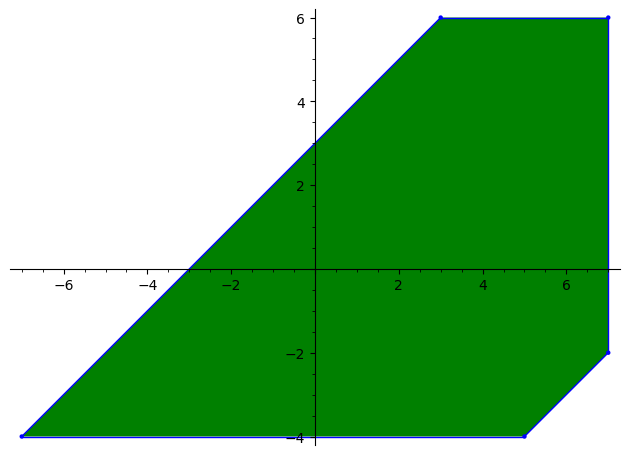

This code should do the same as the previous block, but the variables changed to the appropriate corresponding inequality
integral of x_1^2 over generalized polytrope:
This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (-1, 0) x + 7 >= 0 transformed into generic hyperplane (-1, 0)x + b_1 + h_1 >= 0
An inequality (-1, 1) x + 9 >= 0 transformed into generic hyperplane (-1, 1)x + b_2 + h_2 >= 0
An inequality (0, -1) x + 6 >= 0 transformed into generic hyperplane (0, -1)x + b_3 + h_3 >= 0
An inequality (1, -1) x + 3 >= 0 transformed into generic hyperplane (1, -1)x + b_4 + h_4 >= 0
An inequality (0, 1) x + 4 >= 0 transformed into generic hyperplane (0, 1)x + b_5 + h_5 >= 0
(-1/48*((b_1_2 + b_2_1 - b_2_3 - b_3_2 + h_2 - h_3 + h_4 - h_5)^2 + (b_1_2 + b_2_1 + h_2 + h_4)^2 - (b_1_2 - b_2_1 + b_2_3 - b_3_

In [12]:
## MAIN FUNCTIONS - takes a homogeneous polynomial w over our dim_polytope-dimensional ring R_vars and 
# integrates it over an arbitrary dim_polytope-dimensional integral alcoved polytope P(h). 
# The final output polynomials are in terms of b_i_js (correspond to each hyperplane of alcoved P(h)) 
# and h_i_js (in Todd_count, h_i_js are all set to 0 by the end)

## computes the integral of w(x_1, ..., x_(dim_polytope)) homogeneous in R_vars over an arbitrary (dim_polytope)-dimensional integral 
# alcoved polytope P(h) with P having the same combinatorial type as the unimodular polytope with vertices P_vertices.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P is a fixed alcoved polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to True by default, as we know the hyperplanes of an alcoved polytope.
# INPUT: fixed - If True, then do not generalize right triangle (add in b_i_j) and just keep original polytope and set of vertices. Set to False by default.
# Note that this will just return the weighted count of the original polytope P.

def integral_alcoved_polytope_shifted_by_h(w, P, suppress_output = True, fixed = False):
    # Compute integral_unimodular_polytope_shifted_by_h
    int, b_k_variables, h_variables = integral_unimodular_polytope_shifted_by_h(w, P, suppress_output, fixed)
    # Create dict between b_k_variables and new b_i_j variables
    dict_between_b_k_to_b_i_j = {}
    # Create list of b_i_j_variables.
    b_i_j_variables = []
    # For each b_k, read in it's corresponding hyperplane x_i - x_j <= b_k, and map b_k to b_i_j
    k = 1
    for hyp in P.Hrepresentation():
        #Inequality is of the form x_i - x_j <= b_{ij}. SageMath's notation is to interpret inequality tuple (b, A) as Ax + b >= 0
        #So in our case, our inequality can be rewritten as x_j - x_i + b_{ij} >= 0. We search for the indices i and j respectively.
        #If they are not found, their default value is dim_polytope+1
        hyp_normal = hyp.A()
        i_index = dim_polytope+1
        j_index = dim_polytope+1
        for m in range(len(hyp_normal)):
            if hyp_normal[m] == -1:
                i_index = m+1
            elif hyp_normal[m] == 1:
                j_index = m+1

        # Create variable b_i_j and map b_k to it in our dict. Append to b_i_j_variables. Update k index.
        dict_between_b_k_to_b_i_j[var('b_' + str(k))] =  var('b_' + str(i_index) + '_' + str(j_index))
        b_i_j_variables.append(var('b_' + str(i_index) + '_' + str(j_index)))
        k += 1

    # Use subs to change all a_variables into respective variables
    return int.subs(dict_between_b_k_to_b_i_j), b_i_j_variables, h_variables

## applies Todd operator to integral of w(x_1, ..., x_(dim_polytope)) over an arbitrary integral alcoved polytope P(h)
# with P having the same combinatorial type as the integral unimodular polytope with vertices P_vertices.
# This should result in the weighted integer point count by weighted K-P.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P a fixed alcoved polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to True by default, as we already know the facets of an alcoved polytope.
# INPUT: fixed - If True, then do not generalize right triangle (add in b_i_j) and just keep original polytope and set of vertices. Set to False by default.
# Note that this will just return the weighted count of the original polytope P.

def Todd_alcoved_polytope(w, P, suppress_output = True, fixed = False):
    f, b_i_j_variables, h_variables = integral_alcoved_polytope_shifted_by_h(w, P, suppress_output, fixed)
    g = Todd_multivariate(f, h_variables)
    if g==0:
        return 0
    # This is merely to set the h variables equal to 0, nothing else fancy to it.
    h_vars_dict = {}
    for item in h_variables:
        h_vars_dict[item] = 0
    return g(h_vars_dict).simplify_rational()

# Sample runs of the above code. Only works dimension 2.
if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting sample run.")
else:
    test_polytrope = random_polytrope()
    test_polytrope.show()
    print("This code should do the same as the previous block, but the variables changed to the appropriate corresponding inequality")
    print("integral of x_1^2 over generalized polytrope:")
    print(integral_alcoved_polytope_shifted_by_h(R_vars(x_1^2), test_polytrope, suppress_output = False, fixed = False))
    print()
    print("Todd operator applied on above integral, should result in weighted point count:")
    print(Todd_alcoved_polytope(R_vars(x_1^2), test_polytrope, suppress_output = False, fixed = False))
    print()
    print("Same case as above, but polytope is fixed instead of general:")
    print(Todd_alcoved_polytope(R_vars(x_1^2), test_polytrope, suppress_output = False, fixed = True))

## Examples and Tests Of Our Weighted Count Algorithm
A set of examples for 2D alcoved polytopes and a series of tests verifying the weighted count algorithm is accurate. Can be disabled by setting `omit_testing = True` in the Parameters section.

In [13]:
## FIXED EXAMPLES FOR 2D POLYTOPES

# Code only works for dim_polytope = 2
if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting tests.")
else:
    ## EXAMPLE 1: Generic alcoved polytope, x_1 * x_2.
    print("Example 1: Generic 2D alcoved polytope (named alcoved_polytope), Weight x_1 * x_2")
    
    # Define a weight in terms of R_vars
    w = R_vars(x_1 * x_2)
    
    # Define a 2D alcoved polytope.
    alcoved_polytope = Polyhedron(vertices = [[1, 1], [1, 2], [2, 3], [3, 3], [3, 2], [2, 1]])
    #alcoved_polytope = Polyhedron(ieqs= [[-1, 1, 0], [-1, 0, 1], [1, 1, -1], [1, -1, 1], [3, -1, 0], [3, 0, -1]])
    #alcoved_polytope.plot()
    
    # Verify alcoved_polytope is indeed alcoved:
    if not check_if_alcoved(alcoved_polytope):
        sys.exit()
    
    # Calculate the Todd operator of the integral of w(x) over P(h), evaluate at 0
    f = Todd_unimodular_polytope(w, alcoved_polytope)
    print("Our count by evaluating Todd_unimodular_polytope at b corresponding to alcoved_polytope:")
    print(f(b_1 = -1, b_2 = -1, b_3 = 1, b_4 = 1, b_5 = 3, b_6 = 3))
    print("Manual count by summing w(p) for each p in alcoved_polytope:")
    print(sum(w(p[0], p[1]) for p in alcoved_polytope.integral_points()))
    print()
    
    print("Our count by evaluating Todd_unimodular_polytope at 3*b corresponding to 3*alcoved_polytope:")
    print(f(b_1 = -3, b_2 = -3, b_3 = 3, b_4 = 3, b_5 = 9, b_6 = 9))
    print("Manual count by summing w(p) for each p in 3*alcoved_polytope:")
    print(sum(w(p[0], p[1]) for p in (3*alcoved_polytope).integral_points()))
    print()
    
    print("Printing output from Todd_unimodular_polytope:")
    print(f)
    print("Printing output from Todd_alcoved_polytope (all b_k should be replaced with b_i_j):")
    print(Todd_alcoved_polytope(w, alcoved_polytope, suppress_output = True, fixed = False))
    print()
    
    ## EXAMPLE 2: Degenerate alcoved polytope, x_1^2 * x_2
    ## We use our polytrope function here.
    print("Example 2: Degenerate alcoved polytope (named P), Weight x_1^2 * x_2")
    
    A=[3,4,0,2,1,4]
    w=R_vars(x_1^2*x_2)
    P = polytrope(A) #feed in A in order to get our degenerate alcoved polytope.
    P.plot()
    
    f = Todd_alcoved_polytope(w, P, suppress_output = False, fixed = False)
    print("Our count by evaluating Todd_alcoved_polytope at b corresponding to P:")
    print(f(b_1_2 = 3, b_1_3 = 4, b_2_1 = 0, b_2_3 = 2, b_3_1 = 1)) #Note that b_3_2 is degenerate, so we omit it.
    print("Manual count by summing w(p) for each p in P:")
    print(sum(w(p[0], p[1]) for p in P.integral_points()))
    print()
    
    print("Our count by evaluating Todd_alcoved_polytope at 4*b corresponding to 4*P:")
    print(f(b_1_2 = 12, b_1_3 = 16, b_2_1 = 0, b_2_3 = 8, b_3_1 = 4)) #Note that b_3_2 is degenerate, so we omit it.
    print("Manual count by summing w(p) for each p in 4*P:")
    print(sum(w(p[0], p[1]) for p in (4*P).integral_points()))
    
    print("Printing output from Todd_alcoved_polytope (all b_k should be replaced with b_i_j):")
    print(f)
    print("Printing output from Todd_unimodular_polytope:")
    print(Todd_unimodular_polytope(w, P, suppress_output = True, fixed = False))
    print()


Example 1: Generic 2D alcoved polytope (named alcoved_polytope), Weight x_1 * x_2
This function prints out how each hyperplane is shifted from Ax + b' >= 0 to Ax + (b + h) >= 0. To disable, set suppress_output = True. If fixed = True, then b is fixed at b' instead of being a general variable of the form b_i_j.
An inequality (1, 0) x - 1 >= 0 transformed into generic hyperplane (1, 0)x + b_1 + h_1 >= 0
An inequality (0, 1) x - 1 >= 0 transformed into generic hyperplane (0, 1)x + b_2 + h_2 >= 0
An inequality (1, -1) x + 1 >= 0 transformed into generic hyperplane (1, -1)x + b_3 + h_3 >= 0
An inequality (-1, 1) x + 1 >= 0 transformed into generic hyperplane (-1, 1)x + b_4 + h_4 >= 0
An inequality (-1, 0) x + 3 >= 0 transformed into generic hyperplane (-1, 0)x + b_5 + h_5 >= 0
An inequality (0, -1) x + 3 >= 0 transformed into generic hyperplane (0, -1)x + b_6 + h_6 >= 0
Our count by evaluating Todd_unimodular_polytope at b corresponding to alcoved_polytope:
30
Manual count by summing w(p) f

In [14]:
## TESTING LOTS OF RANDOM EXAMPLES TO VERIFY CODE

## We generate a random weight and random polytrope n times to verify the accuracy of our code.
## Warning: slow for dim_polytope >= 3
def test_Todd(n):
    for i in range(n):
        # Generate random polytope.
        P=random_polytrope()
        
        # Let k be a random integer, we will dilate P by this amount.
        k = randint(0, 10)
        
        # We create rhs_dict to store the right hand side of each of the inequalities, we'll plug this back later
        # into Todd_unimodular_polytope to verify that our polynomial returns the right value.
        # We multiply by k since that represents dilation by k.
        rhs_dict = {}
        current_index = 1
        for hyp in P.Hrepresentation():
            rhs_dict[var('b_' + str(current_index))] = k * hyp.b()
            current_index += 1

        # Generate random weight.
        a=randint(0,2); b=randint(0,2)
        w=R_vars(x_1^a*x_2^b) ## random monomial weight x^a*y^b, degree <=4

        # Calculate Todd count and real count for a random dilate of P, kP.
        todd_count = Todd_unimodular_polytope(w, P, suppress_output = True, fixed = False).subs(rhs_dict)
        real_count = sum(w(*p) for p in (k*P).integral_points())
        if todd_count != real_count: raise ValueError("TEST FAILED!", "P was:", str(P), "w was:", str(w), "Todd count was:", str(todd_count), "real count was:", str(real_count))
        if i % 10 == 0:
            print(i)

if not omit_testing:
    test_Todd(500)
else:
    print("Tests omitted")

Tests omitted


## Converting Weighted Integer Point Count to Weighted Ehrhart and $h^{*}$ Polynomials

#### NOTE TO USER: We defined the parameter fixed in the above case in case the user wanted to compute the weighted count of the original polytope. From here on out, we always assume fixed = False and thus omit it from the function call.

Example: Alcoved polytope, w = x_1 * x_2


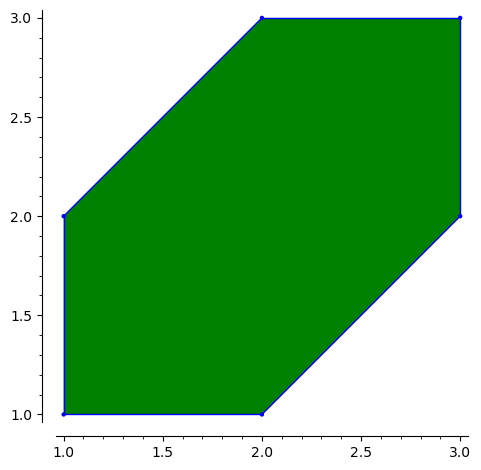

Weighted Ehrhart polynomial
-1/6*b_1_2^3*t^3 + 1/2*b_1_2*b_1_3^2*t^3 - 1/3*b_1_3^3*t^3 + 1/6*b_2_1^3*t^3 + 1/2*b_2_1*b_2_3^2*t^3 - 1/6*b_2_3^3*t^3 - 1/2*b_2_1*b_3_1^2*t^3 + 1/3*b_3_1^3*t^3 - 1/2*b_1_2*b_3_2^2*t^3 + 1/6*b_3_2^3*t^3 + 1/6*(3*b_1_2*t + 2)*b_1_3*t + 1/6*(3*b_1_3^2*t^2 - 3*b_2_1^2*t^2 + 3*b_1_3*t + 1)*b_2_3*t - 1/6*(3*b_2_1*t + 2)*b_3_1*t + 1/6*(3*b_1_2^2*t^2 - 3*b_3_1^2*t^2 - 3*b_3_1*t - 1)*b_3_2*t + 1/6*b_1_2*t - 1/6*b_2_1*t

Weighted h* polynomial
-1/6*(b_1_2^3 - 3*b_1_2*b_1_3^2 + 2*b_1_3^3 - b_2_1^3 - 3*b_2_1*b_2_3^2 + b_2_3^3 + 3*b_2_1*b_3_1^2 - 2*b_3_1^3 + 3*b_1_2*b_3_2^2 - b_3_2^3 + (3*b_1_2 - 2)*b_1_3 - (3*b_1_3^2 - 3*b_2_1^2 - 3*b_1_3 + 1)*b_2_3 - (3*b_2_1 - 2)*b_3_1 - (3*b_1_2^2 - 3*b_3_1^2 + 3*b_3_1 - 1)*b_3_2 - b_1_2 + b_2_1)*t^3 - 1/3*(2*b_1_2^3 - 6*b_1_2*b_1_3^2 + 4*b_1_3^3 - 2*b_2_1^3 - 6*b_2_1*b_2_3^2 + 2*b_2_3^3 + 6*b_2_1*b_3_1^2 - 4*b_3_1^3 + 6*b_1_2*b_3_2^2 - 2*b_3_2^3 - (6*b_1_3^2 - 6*b_2_1^2 - 1)*b_2_3 - (6*b_1_2^2 - 6*b_3_1^2 + 1)*b_3_2 + b_1_2 + 2*b_1

In [15]:
## HELPER FUNCTIONS: convert weighted count -> weighted Ehrhart/h* polnyomials.

# Necessary import
var('t')
from sage.combinat.combinat import eulerian_polynomial

## Computes weighted integer point count (see Todd_unimodular_polytope) and converts it into the weighted Ehrhart polynomial
# by evaluating the weighted count polynomial at the t^th dilate of P, obtained by substituting in b_k = t * b_k.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P a fixed unimodular polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
def weighted_ehrhart_polynomial_unimodular(w, P, suppress_output = True):
    weighted_count_polynomial = Todd_unimodular_polytope(w, P, suppress_output)
    
    # We create rhs_dict to replace each b_k with t * b_k.
    rhs_dict = {}
    for var in weighted_count_polynomial.variables():
        rhs_dict[var] = t * var

    # Now we get the weighted count by substituting above.
    return weighted_count_polynomial.subs(rhs_dict)

## Computes weighted integer point count (see Todd_alcoved_polytope) and converts it into the weighted Ehrhart polynomial
# by evaluating the weighted count polynomial at the t^th dilate of P, obtained by substituting in b_i_j = t * b_i_j.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P a fixed unimodular polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
def weighted_ehrhart_polynomial_alcoved(w, P, suppress_output = True):
    weighted_count_polynomial = Todd_alcoved_polytope(w, P, suppress_output)
    
    # We create rhs_dict to replace each b_k with t * b_k.
    rhs_dict = {}
    for var in weighted_count_polynomial.variables():
        rhs_dict[var] = t * var

    # Now we get the weighted count by substituting above.
    return weighted_count_polynomial.subs(rhs_dict)
    

## Computes weighted h* polynomial by performing a linear transformation on the coefficients of the weighted Ehrhart polynomial
# using Eulerian polynomials.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P a fixed unimodular polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
def weighted_hstar_from_weighted_count_unimodular(w, P, suppress_output = True):
    weighted_ehrhart_polynomial = weighted_ehrhart_polynomial_unimodular(w, P, suppress_output)
    # Compute degree and coefficients of weighted Ehrhart polynomial with respect to t
    deg = weighted_ehrhart_polynomial.degree(t)
    coeffs = weighted_ehrhart_polynomial.coefficients(t, sparse = False)
    # Code above computed the weighted Ehrhart coefficients, now we'll compile these to compute the weighted h* below.
    # We multiply by t to match Beck-Robins notation for the Eulerian numbers (shift all coefficients by 1 degree)
    return((coeffs[0]*(1-t)^(deg)+sum(coeffs[i]*eulerian_polynomial(i)*t*(1-t)^(deg-i) for i in range(1, deg+1))).simplify_rational())

## Computes weighted h* polynomial by performing a linear transformation on the coefficients of the weighted Ehrhart polynomial
# using Eulerian polynomials.
# INPUT: w is a homogeneous weight polynomial in R_vars
# INPUT: P a fixed alcoved polytope - Polyhedron in SageMath.
# INPUT: suppress_output - If True, ignore any print statements from generic_integral_unimodular_polytope. Set to False by default.
def weighted_hstar_from_weighted_count_alcoved(w, P, suppress_output = True):
    weighted_ehrhart_polynomial = weighted_ehrhart_polynomial_alcoved(w, P, suppress_output)
    # Compute degree and coefficients of weighted Ehrhart polynomial with respect to t
    deg = weighted_ehrhart_polynomial.degree(t)
    coeffs = weighted_ehrhart_polynomial.coefficients(t, sparse = False)
    # Code above computed the weighted Ehrhart coefficients, now we'll compile these to compute the weighted h* below.
    # We multiply by t to match Beck-Robins notation for the Eulerian numbers (shift all coefficients by 1 degree)
    return((coeffs[0]*(1-t)^(deg)+sum(coeffs[i]*eulerian_polynomial(i)*t*(1-t)^(deg-i) for i in range(1, deg+1))).simplify_rational())

# Sample runs of above code.

if dim_polytope != 2:
    print("Sample code only works for dimension 2, omitting tests.")
else:
    # Define a 2D alcoved polytope and weight.
    print("Example: Alcoved polytope, w = x_1 * x_2")
    alcoved_polytope = Polyhedron(vertices = [[1, 1], [1, 2], [2, 3], [3, 3], [3, 2], [2, 1]])
    alcoved_polytope.show()
    w = R_vars(x_1)
    
    # Print its weighted ehrhart and h*
    
    print("Weighted Ehrhart polynomial")
    weighted_ehrhart_pol = weighted_ehrhart_polynomial_alcoved(w, alcoved_polytope)
    print(weighted_ehrhart_pol)
    print()
    
    print("Weighted h* polynomial")
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, alcoved_polytope)
    print(weighted_hstar_pol)

## Results and $h^{*}$-experiments

### Non-convexity
This code demonstrates the example in our paper of the $h^{*}$-region being non-convex, i.e. an example where we deform $P$ to $P'$, but note a switch in the sign of the coefficients of $h_{tP + (1-t)P', w}^{*}$.

Non-convexity example, w = -3x + 2y.


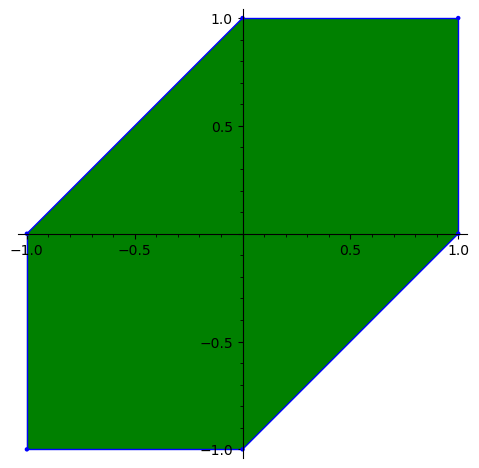

i is 0
10*t^3 + 65*t^2 + 25*t

i is 1
-10*t^3 - 37*t^2 - 7*t

i is 2
-9*t^3 - 39*t^2 - 10*t

i is 3
15*t^3 + 67*t^2 + 18*t



In [16]:
if dim_polytope != 2:
    print("Code block only works in case of dimension 2, omitting.")
else:
    print("Non-convexity example, w = -3x + 2y.")
    # Compute weighted h* polynomial of the generic 2D alcoved polytope
    # with weight w = -3x + 2y. This will return the weighted h* polynomial
    # for any two dimensional polytrope defined by the facets x_i - x_j <= b_ij.
    # (Reminder: there is only one maximal type of 2D alcoved polytrope, in higher dimensions,
    # it is necessary to check chosen b_ij corresponds to same maximal type.)
    alcoved_polytope = polytrope([1, 1, 1, 1, 1, 1])
    alcoved_polytope.show()
    w = R_vars(-3 * x_1 + 2 * x_2)
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, alcoved_polytope)

    # Set up v and h as in paper
    v = [3, 5, 4, 8, 3, 0]
    h = [-1, 2, 0, 1, 0, 0]
    
    for i in range(4):
        print("i is", str(i))
        # Print out polytrope gotten from evaluating at b = (v + i * h)
        polytrope([v[0] + i * h[0], v[1] + i * h[1], v[2] + i * h[2],
                   v[3] + i * h[3], v[4] + i * h[4], v[5] + i * h[5]]).plot()
        # Substitute in v + i * h into our weighted h* polynomial 
        print(weighted_hstar_pol(b_1_2 = v[0] + i * h[0], b_1_3 = v[1] + i * h[1], b_2_1 = v[2] + i * h[2],
                                 b_2_3 = v[3] + i * h[3], b_3_1 = v[4] + i * h[4], b_3_2 = v[5] + i * h[5]))
        print()

### Sign patterns in the case of Dimension 2, Degree 1.
In the case of dimension 2, degree 1, we compute the hyperplane of $h_{P, w}^{*}$ spanned by $h_{P, x}^{*}$ and $h_{P, y}^{*}$ embedded in $\mathbb{R}^{3}$ (for each of the different coefficients). 

This code shows that all sign patterns of the coefficients of $h_{P, w}^{*}$ are possible. We originally conjectured that the coefficients of $h_{P, w}^{*}$ could be any sign pattern except the alternating sign pattern, however, we found some counterexamples of $h_{P, w}^{*}$ with coefficients matching the alternating sign pattern using our code below. Note that this condition is equivalent to checking the minors of the matrix generated by $h_{P, x}^{*}$ and $h_{P, y}^{*}$ to not be of the same sign. 

While we show our code for dimension 2, degree 1, we ran the above tests for all cases dimension 2, degrees 1 to 5 and dimension 3, degrees 1 to 3, and reached the same conclusion disproving our conjecture.

Functions explained below:
- Convert polynomial to dictionary extracting coefficients with respect to variable $t$
- An example of computing $h_{P, x}^{*}$ and $h_{P, y}^{*}$.
- 50 examples of computing a random $P$ and computing the normal vectors to $h_{P, x}^{*}$ and $h_{P, y}^{*}$.
- An explicit counterexample to the conjecture described above.

In [17]:
# Quick helper function as an alternative to coefficients.
# Extracts coefficients of polynomial with respect to variable t.
# INPUT: polynomial in terms of t
# INPUT: degree of said polynomial
def manual_dict(polynomial):
    degree = polynomial.degree(t)
    dict = {}
    for i in range(degree + 1):
        dict[i] = 0 # Added by default to ensure key-value pair always exists
        dict[i] = polynomial.coefficient(t^i)
    return dict

This code blocks runs for a fixed 2D alcoved polytope and enumerates over the monomials of degree 1, mainly x and y,
    to calculate the set of all possible h_{P, w}^{*}.


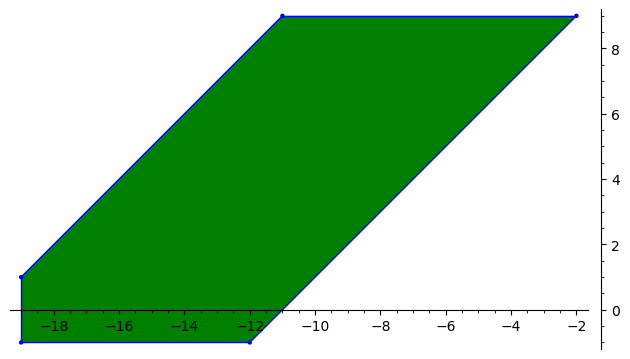

[-11, -2, 20, 9, 19, 1]

Weight x_1
h* polynomial
-809*t^3 - 3961*t^2 - 1204*t
Coefficients of h* polynomial
{0: 0, 1: -1204, 2: -3961, 3: -809}

Weight x_2
h* polynomial
288*t^3 + 1434*t^2 + 442*t
Coefficients of h* polynomial
{0: 0, 1: 442, 2: 1434, 3: 288}



In [18]:
## Computes h_{P, x}^{*} and h_{P, y}^{*} for a random 2D polytope P. 

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:
    print("""This code blocks runs for a fixed 2D alcoved polytope and enumerates over the monomials of degree 1, mainly x and y,
    to calculate the set of all possible h_{P, w}^{*}.""")
    # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
    test_array = [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
    test_polytrope = polytrope(test_array)
    while dim(test_polytrope) < dim_polytope:
        test_polytrope = polytrope([randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))])
    test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
    test_polytrope.show()
    print(test_array)
    print()
    
    # Gotta fill in the appropriate values.
    
    # Weight x_1
    print("Weight x_1")
    w1 = R_vars(x_1)
    # Here it's weighted count
    weighted_count_pol = Todd_alcoved_polytope(w1, test_polytrope)(b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                                                   b_2_1 = test_array[2], b_2_3 = test_array[3], 
                                                                   b_3_1 = test_array[4], b_3_2 = test_array[5])
    # Here's its h* polynomial
    print("h* polynomial")
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w1, test_polytrope)(b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                                                                        b_2_1 = test_array[2], b_2_3 = test_array[3], 
                                                                                        b_3_1 = test_array[4], b_3_2 = test_array[5])
    print(weighted_hstar_pol)
    print("Coefficients of h* polynomial")
    x_dict = manual_dict(weighted_hstar_pol)
    print(x_dict)
    print()

    # Weight x_2
    print("Weight x_2")
    w2 = R_vars(x_2)
    # Here it's weighted count
    weighted_count_pol_2 = Todd_alcoved_polytope(w2, test_polytrope)(b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                                                   b_2_1 = test_array[2], b_2_3 = test_array[3], 
                                                                   b_3_1 = test_array[4], b_3_2 = test_array[5])
    # Here's its h* polynomial
    print("h* polynomial")
    weighted_hstar_pol_2 = weighted_hstar_from_weighted_count_alcoved(w2, test_polytrope)(b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                                                                          b_2_1 = test_array[2], b_2_3 = test_array[3], 
                                                                                          b_3_1 = test_array[4], b_3_2 = test_array[5])
    print(weighted_hstar_pol_2)
    print("Coefficients of h* polynomial")
    y_dict = manual_dict(weighted_hstar_pol_2)
    print(y_dict)
    print()

In [19]:
## Iterates through all h_{P, x}^{*} and h_{P, y}^{*} for a bunch of different examples of P.

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:
    print("""This code blocks runs for 50 different 2D alcoved polytopes and enumerates over the monomials of degree 1, mainly x and y,
    to calculate the set of all possible h_{P, w}^{*}.""")
    print("""Observe that h_{P, w}^{*} (when you drop degree 0 = 0)'s coefficients can be viewed as vectors in R^3. The span of all possible h_{P, w}^{*},
    assuming that h_{P, x}^{*} and h_{P, y}^{*} are linearly independent, form a 2 dimensional hyperplane in R^3. This code outputs 
    the normal vector (or vectors in case of linear dependence of h_{P, x}^{*} and h_{P, y}^{*}) associated with each of these hyperplanes.""")
    for i in range(1, 51):
            
        # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
        test_array = [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
        test_polytrope = polytrope(test_array)
        while dim(test_polytrope) < dim_polytope:
            test_array = [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))]
            test_polytrope = polytrope(test_array)
        test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
            
        # Print out Case i: test_array
        print("Case " + str(i) + ": " + str(test_array))
    
        # Weight x_1, h_{P, x}^{*}
        w1 = R_vars(x_1)
        weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w1, test_polytrope)
        x_dict = manual_dict(weighted_hstar_pol)
        
        # Weight x_2, h_{P, t}^{*}
        w2 = R_vars(x_2)
        weighted_hstar_pol_2 = weighted_hstar_from_weighted_count_alcoved(w2, test_polytrope)
        y_dict = manual_dict(weighted_hstar_pol_2)

        # Extract normal vectors and feed them in as columns to a 3 by 2 matrix. Kernel should return the normal vector(s).
        M = MatrixSpace(ZZ,3, 2)([x_dict[1](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]), 
                                  y_dict[1](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]), 
                                  x_dict[2](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]),
                                  y_dict[2](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                           b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]),
                                  x_dict[3](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]),
                                  y_dict[3](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5])
                                 ])
        print("Kernel (the normal vector(s) to h_{P, x}^{*} and h_{P, y}^{*}):")
        print(M.kernel())
        print("Minors")
        print(M.minors(2))
        print()

    

This code blocks runs for 50 different 2D alcoved polytopes and enumerates over the monomials of degree 1, mainly x and y,
    to calculate the set of all possible h_{P, w}^{*}.
Observe that h_{P, w}^{*} (when you drop degree 0 = 0)'s coefficients can be viewed as vectors in R^3. The span of all possible h_{P, w}^{*},
    assuming that h_{P, x}^{*} and h_{P, y}^{*} are linearly independent, form a 2 dimensional hyperplane in R^3. This code outputs 
    the normal vector (or vectors in case of linear dependence of h_{P, x}^{*} and h_{P, y}^{*}) associated with each of these hyperplanes.
Case 1: [2, -5, 14, 9, 12, 14]
Kernel (the normal vector(s) to h_{P, x}^{*} and h_{P, y}^{*}):
Free module of degree 3 and rank 2 over Integer Ring
Echelon basis matrix:
[   1   34 -170]
[   0   45 -223]
Minors
[0, 0, 0]

Case 2: [14, 10, -9, 1, 1, 10]
Kernel (the normal vector(s) to h_{P, x}^{*} and h_{P, y}^{*}):
Free module of degree 3 and rank 2 over Integer Ring
Echelon basis matrix:
[   2   27 -154

In [20]:
## Example where h_{P, w}^{*} has alternating signs for fixed P.

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:
    print("""Explicit counterexample to our original conjecture that minors are all the same sign.""")
    # Fixed 2D alcoved polytope.
    test_array = [14, 17, 3, 6, -3, 10]
    test_polytrope = polytrope(test_array)
    test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
      
    # Print out Case i: test_array
    print("Counterexample:" + str(test_array))
    
    # Weight x_1, h_{P, x}^{*}
    w1 = R_vars(x_1)
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w1, test_polytrope)
    x_dict = manual_dict(weighted_hstar_pol)
        
    # Weight x_2, h_{P, t}^{*}
    w2 = R_vars(x_2)
    weighted_hstar_pol_2 = weighted_hstar_from_weighted_count_alcoved(w2, test_polytrope)
    y_dict = manual_dict(weighted_hstar_pol_2)

    # Extract normal vectors and feed them in as columns to a 3 by 2 matrix. Kernel should return the normal vector(s).
    M = MatrixSpace(ZZ,3, 2)([x_dict[1](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]), 
                              y_dict[1](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]), 
                                  x_dict[2](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]),
                                  y_dict[2](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                           b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]),
                                  x_dict[3](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5]),
                                  y_dict[3](b_1_2 = test_array[0], b_1_3 = test_array[1], 
                                            b_2_1 = test_array[2], b_2_3 = test_array[3],
                                            b_3_1 = test_array[4], b_3_2 = test_array[5])
                                 ])
    print("Kernel (the normal vector(s) to h_{P, x}^{*} and h_{P, y}^{*}):")
    print(M.kernel())
    print("Minors")
    print(M.minors(2))
    print()

Explicit counterexample to our original conjecture that minors are all the same sign.
Counterexample:[14, 17, 3, 6, -3, 10]
Kernel (the normal vector(s) to h_{P, x}^{*} and h_{P, y}^{*}):
Free module of degree 3 and rank 1 over Integer Ring
Echelon basis matrix:
[ 22  -2 -21]
Minors
[273, -26, -286]



### Dilates $h_{nP, w}^{*}$ and convergence towards the Eulerian polynomial.

Beck-Stapledon showed that if all coefficients of $h_{P, w}^{*}$ are the same sign, then all the roots $h_{nP, w}^{*}$ will converge towards the Eulerian polynomial and satisfy some additional nice propetries as $n \rightarrow \infty$.

In these blocks of code, we show experimentally that even if $h_{P, w}^{*}$ does not intiially have its coefficients matching the same sign, their dilates will eventually do so.
- A random example dimension 2, degree 1, showing the roots of $h_{nP, w}^{*}$ converge towards the roots of the Eulerian polynomial as $n \rightarrow \infty$ 
- 1000 examples of dilating $h_{nP, w}^{*}$ until their roots converge towards the dimension 2, degree 1 cases.
- A fixed example in dimension 2, degree 1 where $h_{nP, w}^{*}$ coefficients have same sign starting after $n \geq 4$.
- Same as before, but dimension 2, degree 2.
- We also include a fixed example in dimension 2, degree 2 where $h_{nP, w}^{*}$ coefficients have same sign starting after $n \geq 32$.

This code blocks runs for a random 2D alcoved polytope and random weight and computes the roots of h_{nP, w}^{*}.


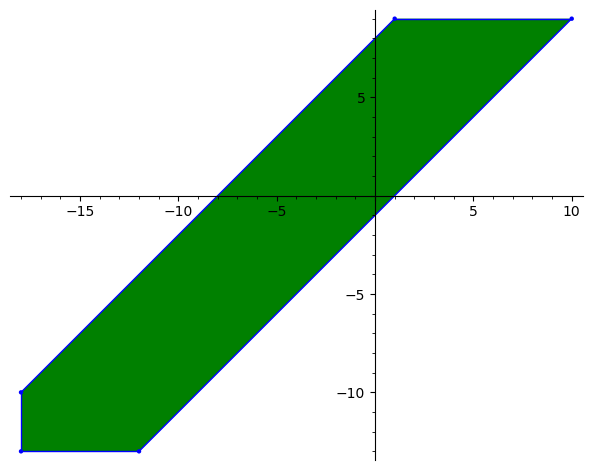

[1, 10, 8, 9, 18, 13]
The roots of t times the Eulerian polynomial A_3(t) are: [(-sqrt(3) - 2, 1), (sqrt(3) - 2, 1), (0, 1)]

Now we compute the roots of h_{nP, w}^{*} as n goes to infinity.

[(-1/10394*sqrt(432331543) - 23985/10394, 1), (1/10394*sqrt(432331543) - 23985/10394, 1), (0, 1)]

[(-1/44773*sqrt(6930187861) - 96102/44773, 1), (1/44773*sqrt(6930187861) - 96102/44773, 1), (0, 1)]

[(-1/34397*sqrt(3899572669) - 72099/34397, 1), (1/34397*sqrt(3899572669) - 72099/34397, 1), (0, 1)]

[(-1/92824*sqrt(27733634617) - 192285/92824, 1), (1/92824*sqrt(27733634617) - 192285/92824, 1), (0, 1)]

[(-5/292144*sqrt(10834054921) - 600921/292144, 1), (5/292144*sqrt(10834054921) - 600921/292144, 1), (0, 1)]

[(-7/140893*sqrt(1273592773) - 288450/140893, 1), (7/140893*sqrt(1273592773) - 288450/140893, 1), (0, 1)]

[(-7/577253*sqrt(21235778299) - 1177857/577253, 1), (7/577253*sqrt(21235778299) - 1177857/577253, 1), (0, 1)]

[(-2/377933*sqrt(110947421641) - 769221/377933, 1), (2/377933*sqrt(11094742

In [21]:
# This code shows an example of a dimension 2, degree 1 combination of P, w, showing the roots of h_{nP, w}^{*} eventually converge towards the roots of the 
# Eulerian polynomial as n goes to infinity.

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:
    print("""This code blocks runs for a random 2D alcoved polytope and random weight and computes the roots of h_{nP, w}^{*}.""")
    # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
    test_array = [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
    test_polytrope = polytrope(test_array)
    while dim(test_polytrope) < dim_polytope:
        test_polytrope = polytrope([randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))])
    test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
    test_polytrope.show()
    print(test_array)
    
    # Here's a random weight.
    a = randint(-100, 100)
    b = randint(-100, 100)
    w = R_vars(a * x_1 + b * x_2)

    # Here it's weighted hstar polynomial.
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, test_polytrope)

    # Define polynomial rings R[t]
    R_t = PolynomialRing(RR, 't').gen()

    # Compute the rotos of t times Eulerian polynomial
    print(f"The roots of t times the Eulerian polynomial A_{dim_polytope + 1}(t) are: " + str((t * eulerian_polynomial(dim_polytope + 1)).roots()))
    print()
    print("Now we compute the roots of h_{nP, w}^{*} as n goes to infinity.")
    print()
    # For each of the dilates h_{nP, w}^{*}, compute the roots
    for i in range(1, 101):
        weighted_hstar_pol_ith_dilate = weighted_hstar_pol(b_1_2 = i * test_array[0], b_1_3 = i * test_array[1], 
                                                           b_2_1 = i * test_array[2], b_2_3 = i * test_array[3], 
                                                           b_3_1 = i * test_array[4], b_3_2 = i * test_array[5])
        # Compute the roots of the above!
        print(weighted_hstar_pol_ith_dilate.roots())
        print()

Case 766
i is 2


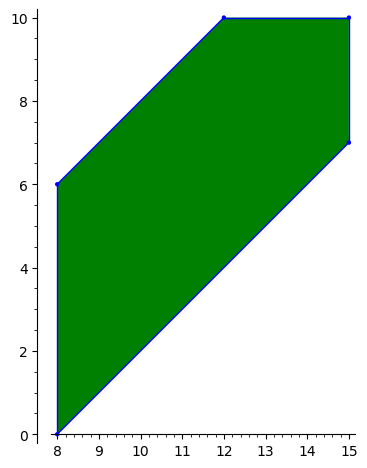

[8, 15, -2, 10, -8, 0]
45*x_1 - 84*x_2
The weighted h* polynomial is
54*t^3 + 3900*t^2 + 2094*t

Case 954
i is 4


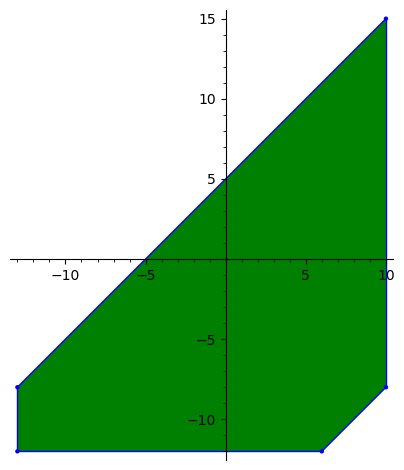

[18, 10, 5, 15, 13, 12]
55*x_1 + 24*x_2
The weighted h* polynomial is
5612*t^3 + 100152*t^2 + 45084*t

Case 965
i is 4


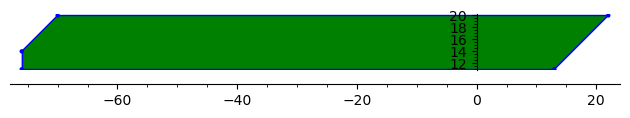

[2, 22, 90, 20, 76, -11]
11*x_1 + 20*x_2
The weighted h* polynomial is
-20506*t^3 - 42764*t^2 - 666*t



In [22]:
# This code computes 1000 examples of dimension 2, weight 1 combinations of P and w, and dilates 
# h_{nP, w}^{*} until h_{nP, w}^{*} all have the same signs. We only print out the cases for which
# h_{P, w}^{*} does not start out with the same signs, but h_{nP, w}^{*} eventually has the same signs
# for n >= 2. In the case of dimension 2, weight 1, it may be that you do not get output.

import random

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:

    for g in range(1, 1001):
        # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
        test_array = [randint(-100,100) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
        test_polytrope = polytrope(test_array)
        while dim(test_polytrope) < dim_polytope:
            test_polytrope = polytrope([randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))])
        test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
        #test_polytrope.show()
        #print(test_array)
        #print()
    
        # Here's a random weight.
        a = random.randint(-100, 100)
        b = random.randint(-100, 100)
        w = R_vars(a * x_1 + b * x_2)
        #print("Weight is", str(w))
        
        # Here it's weighted hstar polynomial.
        weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, test_polytrope)
        #print(weighted_hstar_pol)
    
        # Now iterate through dilates by evaluating at different multiples of b until we get a dilate with all positive or all negative
        
        
        for i in range(1, 1001):
            weighted_hstar_pol_ith_dilate = weighted_hstar_pol(b_1_2 = i * test_array[0], b_1_3 = i * test_array[1], 
                                                               b_2_1 = i * test_array[2], b_2_3 = i * test_array[3], 
                                                               b_3_1 = i * test_array[4], b_3_2 = i * test_array[5])
            deg_h = weighted_hstar_pol_ith_dilate.degree(t)
            all_same_sign = True
            for j in range(0, deg_h):
                if sign(weighted_hstar_pol_ith_dilate.coefficient(t^deg_h)) == -sign(weighted_hstar_pol_ith_dilate.coefficient(t^j)):
                    all_same_sign = False
            if all_same_sign:
                if i != 1:
                    print("Case", g)
                    print("i is", i) 
                    test_polytrope.show()
                    print(test_array)
                    print(w)
                    # Here's its h* polynomial
                    print("The weighted h* polynomial is")
                    print(weighted_hstar_pol_ith_dilate)
                    print()
                break

This code blocks runs for a fixed 2D alcoved polytope and computes h_{nP, w}^{*}
    until we get all the signs of the coefficients match, which occurs for n >= 4.


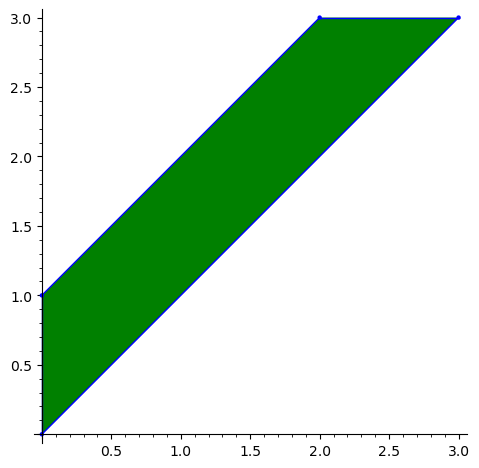

[0, 3, 1, 3, 0, 0]
-8*t^2 + 27*t

-8*t^3 + 60*t^2 + 100*t

-5*t^3 + 280*t^2 + 238*t

28*t^3 + 728*t^2 + 460*t

110*t^3 + 1480*t^2 + 785*t

260*t^3 + 2612*t^2 + 1232*t

497*t^3 + 4200*t^2 + 1820*t

840*t^3 + 6320*t^2 + 2568*t

1308*t^3 + 9048*t^2 + 3495*t



In [23]:
# Fixed example, dimension 2, degree 1

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:
    print("""This code blocks runs for a fixed 2D alcoved polytope and computes h_{nP, w}^{*}
    until we get all the signs of the coefficients match, which occurs for n >= 4.""")
    # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
    test_array = [0, 3, 1, 3, 0, 0] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
    test_polytrope = polytrope(test_array)
    test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
    test_polytrope.show()
    print(test_array)
    
    w = R_vars(79*x_1 - 57*x_2)
    # Here it's weighted hstar polynomial.
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, test_polytrope)

    for i in range(1, 10):
        weighted_hstar_pol_ith_dilate = weighted_hstar_pol(b_1_2 = i * test_array[0], b_1_3 = i * test_array[1], 
                                                           b_2_1 = i * test_array[2], b_2_3 = i * test_array[3], 
                                                           b_3_1 = i * test_array[4], b_3_2 = i * test_array[5])
        # Around dilate 4, we get all same sign.
        deg_h = weighted_hstar_pol_ith_dilate.degree(t)
        all_same_sign = True
        print(weighted_hstar_pol_ith_dilate)
        print()

Case 230
i is 4


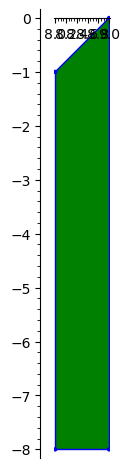

[17, 9, -9, 0, -8, 8]
27*x_1^2 + 98*x_1*x_2 + 68*x_2^2
The weighted h* polynomial is
-81000*t^4 - 779400*t^3 - 576760*t^2 - 11800*t

Case 252
i is 2


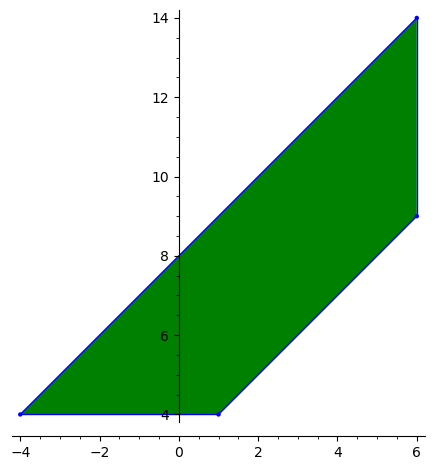

[-3, 6, 8, 14, 4, -4]
78*x_1^2 + 50*x_1*x_2 - 26*x_2^2
The weighted h* polynomial is
20328*t^4 + 489602*t^3 + 744412*t^2 + 106458*t

Case 363
i is 3


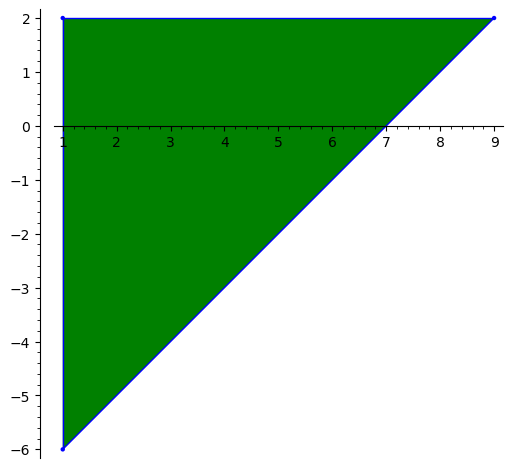

[7, 9, 1, 2, -1, 6]
-13*x_1^2 + 74*x_1*x_2 + 82*x_2^2
The weighted h* polynomial is
24035*t^4 + 1207293*t^3 + 2049525*t^2 + 306475*t

Case 427
i is 2


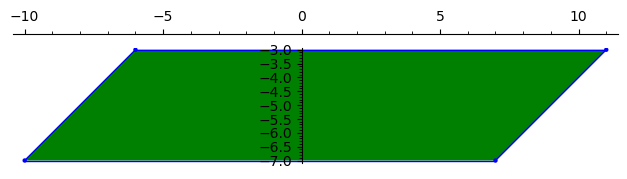

[14, 11, 3, -3, 10, 7]
-95*x_1^2 + 34*x_1*x_2 + 99*x_2^2
The weighted h* polynomial is
231847*t^4 + 1895295*t^3 + 1232381*t^2 + 8925*t

Case 437
i is 2


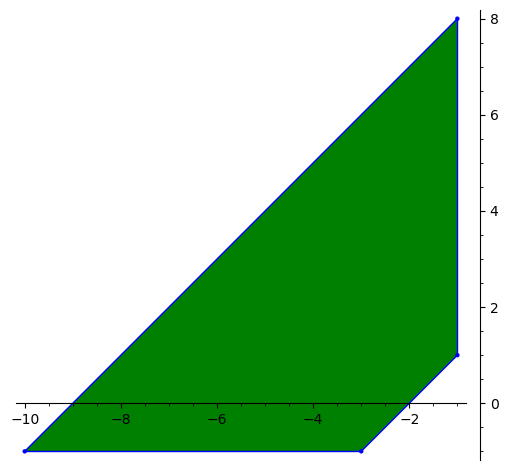

[-2, -1, 9, 8, 10, 1]
-31*x_1^2 - 6*x_1*x_2 + 75*x_2^2
The weighted h* polynomial is
5486*t^4 + 211844*t^3 + 352694*t^2 + 52920*t

Case 548
i is 2


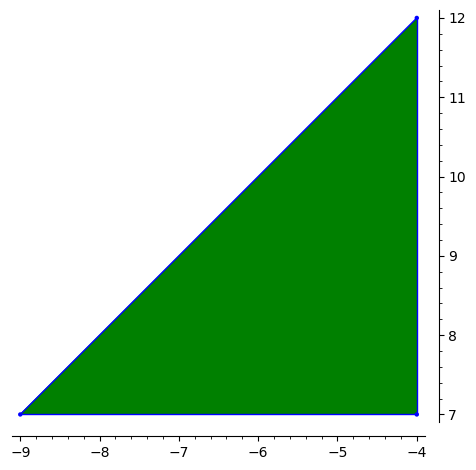

[-11, -4, 16, 12, 9, -7]
3*x_1^2 + 33*x_1*x_2 + 20*x_2^2
The weighted h* polynomial is
2346*t^4 + 55359*t^3 + 86504*t^2 + 12991*t

Case 575
i is 2


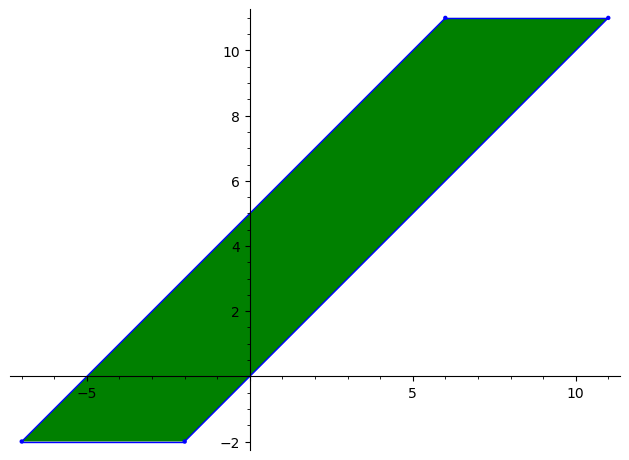

[0, 11, 5, 11, 7, 2]
83*x_1^2 + 16*x_1*x_2 - 55*x_2^2
The weighted h* polynomial is
65325*t^4 + 1436309*t^3 + 2081351*t^2 + 281655*t

Case 577
i is 2


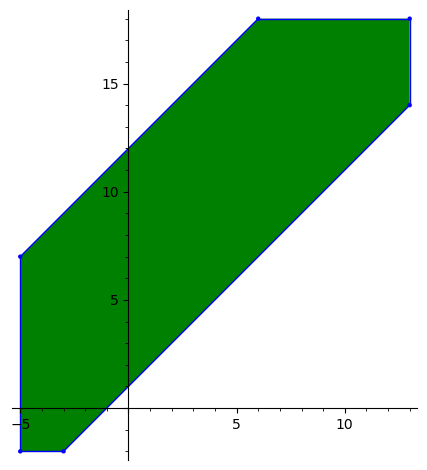

[-1, 13, 12, 18, 5, 2]
86*x_1^2 + 47*x_1*x_2 - 45*x_2^2
The weighted h* polynomial is
55759*t^4 + 2635208*t^3 + 4333487*t^2 + 623562*t

Case 580
i is 2


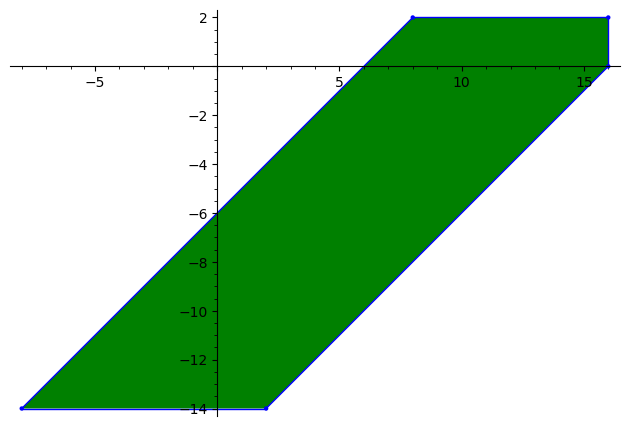

[16, 16, -6, 2, 8, 14]
13*x_1^2 - 81*x_1*x_2 - 22*x_2^2
The weighted h* polynomial is
568431*t^4 + 4435255*t^3 + 2890085*t^2 + 51701*t

Case 586
i is 2


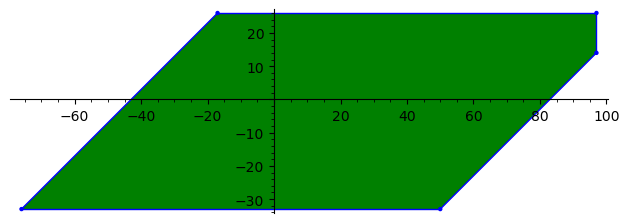

[83, 97, 43, 26, 76, 33]
14*x_1^2 - 100*x_1*x_2 - 15*x_2^2
The weighted h* polynomial is
-25953597*t^4 - 580923621*t^3 - 806461631*t^2 - 101137951*t

Case 741
i is 2


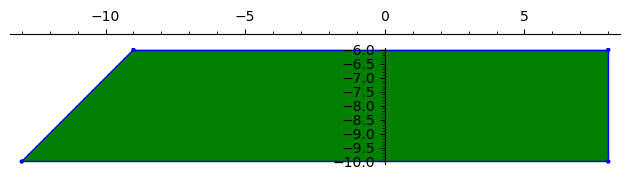

[18, 8, 3, -6, 13, 10]
91*x_1^2 + 56*x_1*x_2 - 52*x_2^2
The weighted h* polynomial is
147945*t^4 + 3135025*t^3 + 4508275*t^2 + 608115*t

Case 825
i is 230


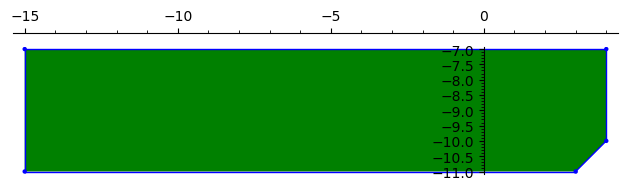

[14, 4, 8, -7, 15, 11]
92*x_1^2 + 5*x_1*x_2 - 71*x_2^2
The weighted h* polynomial is
-514708528295*t^4 - 3609628573940*t^3 - 2067784086735*t^2 - 760141030*t

Case 851
i is 109


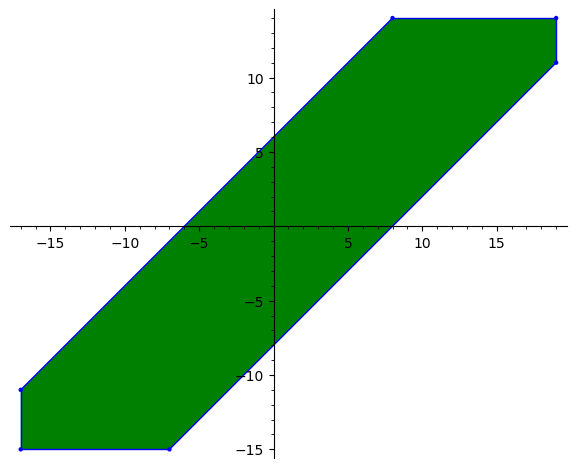

[8, 19, 6, 14, 17, 15]
88*x_1^2 - 77*x_1*x_2 - 29*x_2^2
The weighted h* polynomial is
-57030700633*t^4 - 400017611823*t^3 - 229284265657*t^2 - 119558830*t

Case 892
i is 2


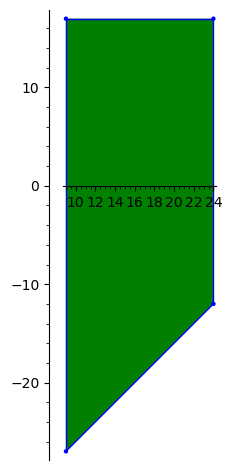

[36, 24, 8, 17, -9, 27]
28*x_1^2 + 81*x_1*x_2 - 51*x_2^2
The weighted h* polynomial is
3027339*t^4 + 24584170*t^3 + 17574223*t^2 + 689068*t

Case 914
i is 2


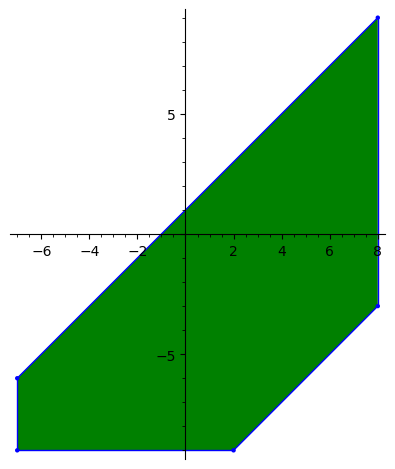

[11, 8, 1, 9, 7, 9]
-37*x_1^2 + 87*x_1*x_2 + 3*x_2^2
The weighted h* polynomial is
-145142*t^4 - 1098743*t^3 - 670268*t^2 - 1767*t



In [24]:
# Same deal, but with dimension 2, degree 2. More interesting cases here.

import random

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:

    for g in range(1, 1001):
        # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
        test_array = [randint(-100,100) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
        test_polytrope = polytrope(test_array)
        while dim(test_polytrope) < dim_polytope:
            test_polytrope = polytrope([randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))])
        test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
        #test_polytrope.show()
        #print(test_array)
        #print()
    
        # Here's a random weight.
        a = random.randint(-100, 100)
        b = random.randint(-100, 100)
        c = random.randint(-100, 100)
        w = R_vars(a * x_1^2 + b * x_1*x_2 + c * x_2^2)
        #print("Weight is", str(w))
        
        # Here it's weighted hstar polynomial.
        weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, test_polytrope)
        #print(weighted_hstar_pol)
    
        # Now iterate through dilates by evaluating at different multiples of b until we get a dilate with all positive or all negative
        
        
        for i in range(1, 1001):
            weighted_hstar_pol_ith_dilate = weighted_hstar_pol(b_1_2 = i * test_array[0], b_1_3 = i * test_array[1], 
                                                               b_2_1 = i * test_array[2], b_2_3 = i * test_array[3], 
                                                               b_3_1 = i * test_array[4], b_3_2 = i * test_array[5])
            deg_h = weighted_hstar_pol_ith_dilate.degree(t)
            all_same_sign = True
            for j in range(0, deg_h):
                if sign(weighted_hstar_pol_ith_dilate.coefficient(t^deg_h)) == -sign(weighted_hstar_pol_ith_dilate.coefficient(t^j)):
                    all_same_sign = False
            if all_same_sign:
                if i != 1:
                    print("Case", g)
                    print("i is", i) 
                    test_polytrope.show()
                    print(test_array)
                    print(w)
                    # Here's its h* polynomial
                    print("The weighted h* polynomial is")
                    print(weighted_hstar_pol_ith_dilate)
                    print()
                break

This code blocks runs for a fixed 2D alcoved polytope and computes h_{nP, w}^{*}
    until we get all the signs of the coefficients match, which occurs for n >= 32.


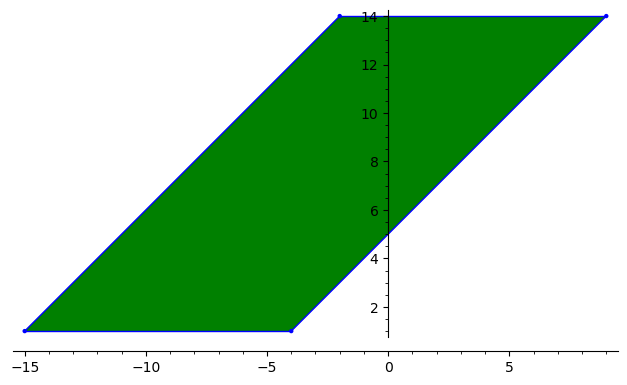

[-5, 9, 16, 14, 15, -1]
10610*t^4 + 36725*t^3 - 41511*t^2 - 15834*t

89775*t^4 + 249961*t^3 - 379215*t^2 - 120681*t

301264*t^4 + 710895*t^3 - 1414629*t^2 - 408340*t

698836*t^4 + 1380604*t^3 - 3659380*t^2 - 982620*t

1326240*t^4 + 2110055*t^3 - 7735205*t^2 - 1957340*t

2217215*t^4 + 2640105*t^3 - 14373951*t^2 - 3456329*t

3395490*t^4 + 2601501*t^3 - 24417575*t^2 - 5613426*t

4874784*t^4 + 1514880*t^3 - 38818144*t^2 - 8572480*t

6658806*t^4 - 1209231*t^3 - 58637835*t^2 - 12487350*t

8741255*t^4 - 6270415*t^3 - 85048935*t^2 - 17521905*t

11105820*t^4 - 14478365*t^3 - 119333841*t^2 - 23850024*t

13726180*t^4 - 26752884*t^3 - 162885060*t^2 - 31655596*t

16566004*t^4 - 44123885*t^3 - 217205209*t^2 - 41132520*t

19578951*t^4 - 67731391*t^3 - 283907015*t^2 - 52484705*t

22708670*t^4 - 98825535*t^3 - 364713315*t^2 - 65926070*t

25888800*t^4 - 138766560*t^3 - 461457056*t^2 - 81680544*t

29042970*t^4 - 189024819*t^3 - 576081295*t^2 - 99982066*t

32084799*t^4 - 251180775*t^3 - 710639199*t^2 - 12

In [25]:
# Fixed example, dimension 2, degree 2

if dim_polytope != 2:
    print("This code block works only for dimension 2, omitting.")
else:
    print("""This code blocks runs for a fixed 2D alcoved polytope and computes h_{nP, w}^{*}
    until we get all the signs of the coefficients match, which occurs for n >= 32.""")
    # Here's a 2D random polytrope. Copies code from random_polytrope, but allows us to keep the array.
    test_array = [-5, 9, 16, 14, 15, -1] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))] # [randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))], [1, 1, 1, 1, 1, 1]
    test_polytrope = polytrope(test_array)
    while dim(test_polytrope) < dim_polytope:
        test_polytrope = polytrope([randint(-20,20) for i in range((dim_polytope+1) * (dim_polytope))])
    test_array = polytrope_to_b(test_polytrope) #Squishes back degenerate b_i_j into satisfying triangle inequalities
    test_polytrope.show()
    print(test_array)
    
    w = R_vars(-51*x_1^2 + 25*x_1*x_2 + 27*x_2^2)
    # Here it's weighted hstar polynomial.
    weighted_hstar_pol = weighted_hstar_from_weighted_count_alcoved(w, test_polytrope)

    for i in range(1, 201):
        weighted_hstar_pol_ith_dilate = weighted_hstar_pol(b_1_2 = i * test_array[0], b_1_3 = i * test_array[1], 
                                                           b_2_1 = i * test_array[2], b_2_3 = i * test_array[3], 
                                                           b_3_1 = i * test_array[4], b_3_2 = i * test_array[5])
        # Around dilate 32, we get all same sign.
        deg_h = weighted_hstar_pol_ith_dilate.degree(t)
        all_same_sign = True
        print(weighted_hstar_pol_ith_dilate)
        print()